# Определение уязвимых групп населения

Задача:
* кластеризовать регионы России и определить, какие из них наиболее
остро нуждаются в помощи малообеспеченным/неблагополучным
слоям населения;
* описать группы населения, сталкивающиеся с бедностью;
* определить:
    * влияет ли число детей, пенсионеров и других социально уязвимых
групп на уровень бедности в регионе;
    * связаны ли уровень бедности/социального неблагополучия с
производством и потреблением в регионе;
    * какие ещё зависимости можно наблюдать относительно
социально незащищённых слоёв населения.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
from sklearn import cluster, metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.mixture import GaussianMixture
from statsmodels.stats.proportion import proportions_chisquare

import warnings # для игнорирования предупреждений
#Игнорируем варнинги
warnings.filterwarnings('ignore')

## 0. Функция для обработки названий регионов

Для начала работы загрузим список субъектов РФ с сайта [Wikipedia](https://ru.wikipedia.org/wiki/Коды_субъектов_Российской_Федерации) и преобразуем их словарь.

In [2]:
import requests
from bs4 import BeautifulSoup
import re

url = "https://ru.wikipedia.org/wiki/Коды_субъектов_Российской_Федерации"
regions = pd.read_html(requests.get(url).text, match='Наименование субъекта')[0]

regions['Наименование субъекта'] = regions['Наименование субъекта'].str.replace('\xa0', ' ')
regions = regions[regions['Наименование субъекта'] != 'Территории, находящиеся за пределами РФ и обслуживаемые Управлением режимных объектов МВД России, Байконур']
regions =regions.drop(['Код ГИБДД', 'Код ОКАТО и ОКТМО', 'Код ISO 3166-2[1]', 'Код ГОСТ 7.67-2003'], axis=1)

regions_to_delete = ['Ханты-Мансийский автономный округ — Югра', 'Ямало-Ненецкий автономный округ', 'Тюменская область', 'Ненецкий автономный округ', 'Архангельская область', 'Омская область']
cleaned_regions = regions[~regions['Наименование субъекта'].isin(regions_to_delete)]

#функция для создания вспомогательного столбца short
def short_regions(region):
    replace_dict = {'республика':'', 'автономная':'','край':'', 'область':'', 'автономный округ':'','народная':'', 'северная':'', 'автономная область':'', 'эл':'', '(':',', ')':'', ' — ':',',' - ':',',' ':''}
    reg_replace = {'саха': "республика саха", "алтай": "республика алтай", "коми": "республика коми"}
    for old, new in replace_dict.items():
        region = region.lower().replace(old, new)
            
    region = region.split(',')
    
    for key in reg_replace:
        if key in region:
            region.remove(key)
            region.append(reg_replace[key])
    return region

cleaned_regions['short'] = cleaned_regions['Наименование субъекта'].apply(short_regions)

regions_dict = {element: row['Наименование субъекта'] for _, row in cleaned_regions.iterrows() for element in row['short']}

#Добавляем в словарь исключения, которые не удалось обработать функцией change_name
regions_dict.update({'санкт':'Санкт-Петербург', 
                     'bладимирская': 'Владимирская область',
                     'bоронежская':'Воронежская область',
                     'bологодская':'Вологодская область',
                     'bолгоградская область':'Волгоградская область',
                     'тюменская область без автономного округа':'Тюменская область',
                     'тюменская область без\nавтономных округов':'Тюменская область',
                     'юменская обл.без данных по':'Тюменская область',
                     'рхангельская обл. без данных по':'Архангельская область',
                     'юменская область (кроме': 'Тюменская область',
                     'рхангельская область (кроме': 'Архангельская область'})

In [3]:
# Функция для преобразования наименований субъектов:

def change_name(name):
    name_lower = name.lower()

    for n, region in regions_dict.items():
        if n in name_lower:
            return region

    #Далее обрабатываем исключения
    
    if re.search(r'\bомская\b(?!.*томская)', name_lower):
        return "Омская область"

    if any(keyword in name_lower for keyword in ['ханты', 'югра']):
        return 'Ханты-Мансийский автономный округ — Югра'
    elif 'ямало' in name_lower:
        return 'Ямало-Ненецкий автономный округ'
    elif 'тюменская' in name_lower:
        return 'Тюменская область'

    if all(keyword in name_lower for keyword in ['ненецкий', 'архангельск']):
        return "Ненецкий автономный округ"
    elif re.search(r'\bненецкий\b', name_lower) and not re.search(r'\bямало-ненецкий\b', name_lower):
        return "Ненецкий автономный округ"
    elif 'архангельск' in name_lower:
        return "Архангельская область"

    print(f"No match found for '{name_lower}'") #Выводим строки, которые не удалось обработать
    return name

## 1. Обработка данных

### 1.1. Подгрузка данных из таблиц

In [4]:
# создадим пустые списки, которые будем наполнять в процессе обработки таблицы, после чего мы сможем 
# использовать эти списки для формирования одного общего набора данных.

tables = []
columns = []

#### 1.1.1 Доходы населения

In [5]:

#Среднедущевые доходы населения

cash_capita = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx')

# Исключим строки содержащие федеральный округ, федерация и район
district = cash_capita[cash_capita['region'].str.contains('федеральный округ|Федерация|район|числе')].index
cash_capita.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
cash_capita['region'] = cash_capita['region'].apply(change_name)

cash_capita.set_index('region', inplace=True)
cash_capita = cash_capita[~cash_capita.index.duplicated(keep='last')]

cash_capita = cash_capita.mean(axis=1)

print('Среднедушевые денежные доходы (в месяц), руб')
cash_capita.head()

Среднедушевые денежные доходы (в месяц), руб


region
Белгородская область    30692.500000
Брянская область        26015.500000
Владимирская область    23908.333333
Воронежская область     30422.833333
Ивановская область      24567.833333
dtype: float64

In [6]:
# Реальные доходы населения

real_incomes = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', 1)

# Исключим строки содержащие федеральный округ, федерация и район
district = real_incomes[real_incomes['region'].str.contains('федеральный округ|Федерация|район|числе')].index
real_incomes.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
real_incomes['region'] = real_incomes['region'].apply(change_name)

real_incomes.set_index('region', inplace=True)
real_incomes = real_incomes[~real_incomes.index.duplicated(keep='last')]

#Заполняем пустые значения нулями, потому что в датасете нет информации о Республике Крым и г. Севатостополь до 2015 года
real_incomes = real_incomes.fillna(0)

# Преобразуем проценты в множители (например, 102% станет 1.02, 98% станет 0.98 и т.д.)
multipliers = real_incomes.iloc[:, 1:] / 100

# Применяем множители последовательно, начиная со 100% в базовом году
cumulative_growth = multipliers.cumprod(axis=1)

# Получаем конечный множитель роста или падения, сравнивая последний год с базовым значением 100%
# Мы отнимаем 1, потому что базовое значение было 100% или 1.0
real_incomes = cumulative_growth.iloc[:, -1] - 1

print('Реальные денежные доходы (в процентах к предыдущему году), %')
real_incomes.head()

Реальные денежные доходы (в процентах к предыдущему году), %


region
Белгородская область   -0.026988
Брянская область       -0.066900
Владимирская область   -0.104430
Воронежская область    -0.120706
Ивановская область     -0.097117
Name: 2020, dtype: float64

In [7]:
# Номинальная заработная плата

formal_wage_paid = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', 2)

# Исключим строки содержащие федеральный округ, федерация и район
district = formal_wage_paid[formal_wage_paid['region'].str.contains('федеральный округ|Федерация|район|числе')].index
formal_wage_paid.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
formal_wage_paid['region'] = formal_wage_paid['region'].apply(change_name)

formal_wage_paid.set_index('region', inplace=True)
formal_wage_paid = formal_wage_paid[~formal_wage_paid.index.duplicated(keep='last')]

formal_wage_paid = formal_wage_paid.mean(axis=1)

print('Номинальная заработная плата (в месяц), руб')
formal_wage_paid.head()

Номинальная заработная плата (в месяц), руб


region
Белгородская область    30920.333333
Брянская область        26399.166667
Владимирская область    29127.166667
Воронежская область     30077.000000
Ивановская область      24856.666667
dtype: float64

In [8]:
# Реальная заработная плата

real_pay = pd.read_excel('data/cash_real_income_wages_2015_2020.xlsx', 3)

# Исключим строки содержащие федеральный округ, федерация и район
district = real_pay[real_pay['region'].str.contains('федеральный округ|Федерация|район|числе')].index
real_pay.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
real_pay['region'] = real_pay['region'].apply(change_name)

real_pay.set_index('region', inplace=True)
real_pay = real_pay[~real_pay.index.duplicated(keep='last')]

# Преобразуем проценты в множители (например, 102% станет 1.02, 98% станет 0.98 и т.д.)
multipliers = real_pay.iloc[:, 1:] / 100

# Применяем множители последовательно, начиная со 100% в базовом году
cumulative_growth = multipliers.cumprod(axis=1)

# Получаем конечный множитель роста или падения, сравнивая последний год с базовым значением 100%
# Мы отнимаем 1, потому что базовое значение было 100% или 1.0
real_pay = cumulative_growth.iloc[:, -1] - 1

print('Реальная заработная плата (в месяц), руб')
real_pay.head()

Реальная заработная плата (в месяц), руб


region
Белгородская область    0.226147
Брянская область        0.163988
Владимирская область    0.204056
Воронежская область     0.181671
Ивановская область      0.095723
Name: 2020, dtype: float64

In [9]:
# добавляем таблицы в список

for df in [cash_capita, real_incomes, real_pay, formal_wage_paid]:
    tables.append(df)
    
for col in ['cash_capita', 'real_incomes', 'real_pay', 'formal_wage_paid']:
    columns.append(col)

#### 1.1.2. Число умерших на первом году жизни детей за год

In [10]:
# Детская смертность в сельской местности

rural = pd.read_excel('data/child_mortality_rural_1990_2021.xls', skiprows=2)

# Удалим лишние столбцы
rural.drop(['Unnamed: 1', 'Unnamed: 2'], axis = 1, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = rural[rural['Unnamed: 0'].str.contains('федеральный округ|Федерация|район|Ордынский|Корякский|кроме|Коми-Пермяцкий|Таймырский|Эвенкийский|Агинский')].index
# Удаляем пробелы перед названием регионов
rural['Unnamed: 0'] = rural['Unnamed: 0'].str.strip()
rural.drop(district, axis = 0, inplace=True)

rural.rename(columns={'Unnamed: 0':"region"}, inplace=True)

# Унифицируем названия регионов
rural['region'] = rural['region'].apply(change_name)

rural.set_index('region', inplace=True)
rural = rural[~rural.index.duplicated(keep='first')]

In [11]:

# Детская смертность в городской местности

urban = pd.read_excel('data/child_mortality_urban_1990_2021.xls', skiprows=2)

# Удалим лишние столбцы
urban.drop(['Unnamed: 1', 'Unnamed: 2'], axis = 1, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = urban[urban['Unnamed: 0'].str.contains('федеральный округ|Федерация|район|Ордынский|Корякский|кроме|Коми-Пермяцкий|Таймырский|Эвенкийский|Агинский')].index
# Удаляем пробелы перед названием регионов
urban['Unnamed: 0'] = urban['Unnamed: 0'].str.strip()
urban.drop(district, axis = 0, inplace=True)

urban.rename(columns={'Unnamed: 0':"region"}, inplace=True)

# Унифицируем названия регионов
urban['region'] = urban['region'].apply(change_name)

urban.set_index('region', inplace=True)
urban = urban[~urban.index.duplicated(keep='first')]

# Объединяем детскую смертность с городов и регионов
child_mortality = rural.add(urban)
child_mortality = child_mortality.mean(axis=1)

# добавляем таблицы в список
tables.append(child_mortality)
columns.append('child_mortality')

print('Количетсво умерших детей, чел.')
child_mortality.head()

Количетсво умерших детей, чел.


region
Белгородская область    139.21875
Брянская область        154.40625
Владимирская область    142.78125
Воронежская область     216.31250
Ивановская область      116.25000
dtype: float64

#### 1.1.3 Люди с инвалидностью

In [12]:

disabled = pd.read_csv('data/disabled_total_by_age_2017_2022.csv')

# Исключаем строки содержащие федеральный округ, федерация и район
district = disabled[disabled['region'].str.contains('федеральный округ|Федерация|район|Байконур')].index
disabled.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
disabled['region'] = disabled['region'].apply(change_name)

disabled.set_index('region', inplace=True)

# Выполняем группировку по году
disabled['date'] = pd.to_datetime(disabled['date']).dt.year
disabled = disabled.groupby(['region','date'])['total'].sum().unstack()
disabled = disabled.mean(axis=1)

# добавляем таблицы в список
tables.append(disabled)
columns.append('disabled')

print('Количество инвалидов, чел.')
disabled.head()

Количество инвалидов, чел.


region
Алтайский край           1.816918e+06
Амурская область         6.893337e+05
Архангельская область    9.065442e+05
Астраханская область     4.636028e+05
Белгородская область     2.155028e+06
dtype: float64

#### 1.1.4 Сведения о заболеваемости алкоголизмом и наркоманией

In [13]:

alco = pd.read_excel('data/drug_alco.xlsx', 0)
alco1718 = pd.read_excel('data/drug_alco.xlsx', 1)

# Исключаем строки содержащие федеральный округ, федерация и район
district = alco[alco['region'].str.contains('федеральный округ|Федерация|район|Байконур')].index
alco.drop(district, axis = 0, inplace=True)
district = alco1718[alco1718['region'].str.contains('федеральный округ|Федерация|район|Байконур|медицинское')].index
alco1718.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
alco['region'] = alco['region'].apply(change_name)
alco1718['region'] = alco1718['region'].apply(change_name)

alco.set_index('region', inplace=True)
alco1718.set_index('region', inplace=True)

alco = pd.concat([alco, alco1718], axis=1).sort_index()
alco = alco.mean(axis=1)

tables.append(alco)
columns.append('alco')

print('Количество человек с алкогольной зависимостью поставленных на учёт на 100 тысяч человек')
display(alco.head())

Количество человек с алкогольной зависимостью поставленных на учёт на 100 тысяч человек


region
Алтайский край           146.342857
Амурская область         117.421429
Архангельская область     88.981818
Астраханская область      98.545455
Белгородская область      71.728571
dtype: object

In [14]:

drugs = pd.read_excel('data/drug_alco.xlsx', 2)
drugs1718 = pd.read_excel('data/drug_alco.xlsx', 3)

# Исключаем строки содержащие федеральный округ, федерация и район
district = drugs[drugs['region'].str.contains('федеральный округ|Федерация|район|Байконур')].index
drugs.drop(district, axis = 0, inplace=True)
district = drugs1718[drugs1718['region'].str.contains('федеральный округ|Федерация|район|Байконур|медицинское')].index
drugs1718.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
drugs['region'] = drugs['region'].apply(change_name)
drugs1718['region'] = drugs1718['region'].apply(change_name)

drugs.set_index('region', inplace=True)
drugs1718.set_index('region', inplace=True)

drugs = pd.concat([drugs, drugs1718], axis=1).sort_index()
drugs = drugs.mean(axis=1)

tables.append(drugs)
columns.append('drugs')

print('Количество человек с наркотической зависимостью поставленных на учёт на 100 тысяч человек')
drugs.head()

Количество человек с наркотической зависимостью поставленных на учёт на 100 тысяч человек


region
Алтайский край           26.207143
Амурская область         25.092857
Архангельская область     3.990909
Астраханская область           7.0
Белгородская область      4.007143
dtype: object

#### 1.1.5 Валовой региональный продукт на душу населения, в рублях.

In [15]:
gross = pd.read_excel('data/gross_regional_product_1996_2020.xls', 
                      header=2)

# Исключим строки содержащие федеральный округ, федерация и район
district = gross[gross['Unnamed: 0'].str.contains('федеральный округ|Федерация|район|кроме')].index
# Удаляем пробелы перед названием регионов
gross['Unnamed: 0'] = gross['Unnamed: 0'].str.strip()
gross.drop(district, axis = 0, inplace=True)

gross.rename(columns={'Unnamed: 0':"region"}, inplace=True)

# Унифицируем названия регионов
gross['region'] = gross['region'].apply(change_name)

gross.set_index('region', inplace=True)
gross = gross.mean(axis=1)

tables.append(gross)
columns.append('gross')

print('Валовой региональный продукт на душу населения, в рублях.')
gross.head()

Валовой региональный продукт на душу населения, в рублях.


region
Белгородская область    244680.468
Брянская область        123532.820
Владимирская область    149340.336
Воронежская область     168933.316
Ивановская область       98471.104
dtype: float64

#### 1.1.6 Оценка домохозяйствами состояния занимаемого ими жилого помещения

In [16]:
housing = pd.read_excel('data/housing_2020.xlsx')

housing.rename(columns={'Регион':"region"}, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = housing[housing['region'].str.contains('федеральный округ|Федерация|район')].index
housing.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
housing['region'] = housing['region'].apply(change_name)

housing.set_index('region', inplace=True)

housing_conditions = pd.read_excel('data/housing_2020.xlsx', 1)
housing_conditions.rename(columns={'Регион':"region"}, inplace=True)

housing_conditions = housing_conditions.dropna(subset=['region'])

# Исключим строки содержащие федеральный округ, федерация и район
district = housing_conditions[housing_conditions['region'].str.contains('федеральный округ|Федерация|район|здесь и далее')].index
housing_conditions.drop(district, axis = 0, inplace=True)

housing_conditions['region'] = housing_conditions['region'].apply(lambda x: x.replace('B','В'))

# Унифицируем названия регионов
housing_conditions['region'] = housing_conditions['region'].apply(change_name)

housing_conditions.set_index('region', inplace=True)

print('Средняя жилая площадь на человека, м^2')
living_area = housing[['Размер жилой площади в расчете на члена домохозяйства']]

tables.append(living_area)
columns.append('living_area')

display(living_area.head())

print('Плохие условия проживания')
# ВЫбираем столбец с плохими условиями
poor_living_conditions = housing_conditions[['из них указавшие: на плохое состояние или очень плохое состояние жилого помещения и на стесненность проживания']]
# Удалаям последнюю строку
poor_living_conditions = poor_living_conditions.drop(poor_living_conditions.index[-1])
poor_living_conditions.rename(columns={'из них указавшие: на плохое состояние или очень плохое состояние жилого помещения и на стесненность проживания':'poor_living'}, inplace=True)

tables.append(poor_living_conditions)
columns.append('poor_living_conditions')

display(poor_living_conditions.head())

Средняя жилая площадь на человека, м^2


,Размер жилой площади в расчете на члена домохозяйства
region,
Белгородская область,17.8
Брянская область,24.1
Владимирская область,16.1
Воронежская область,19.9
Ивановская область,18.1


Плохие условия проживания


,poor_living
region,
Белгородская область,0.4
Брянская область,0.0
Владимирская область,0.0
Воронежская область,0.1
Ивановская область,0.9


#### 1.1.7 Заболеваемость

In [17]:
diseases = pd.read_excel('data/morbidity_2005_2020_age_disease.xls', skiprows=2)
diseases.rename(columns={'Unnamed: 0':"region",'Unnamed: 1':"Заболевания",'Unnamed: 2':"Группа"}, inplace=True)


# Исключим строки содержащие федеральный округ, федерация и район
district = diseases[diseases['region'].str.contains('федеральный округ|Федерация|район')].index
# Удаляем пробелы перед названием регионов
diseases['region'] = diseases['region'].str.strip()
diseases.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
diseases['region'] = diseases['region'].apply(change_name)

# Назначим регион как индекс
diseases.set_index('region', inplace=True)
diseases = diseases[diseases['Группа'] == 'Всего']

# Выделим статистику по общем заболиваемости
general_morbidity = diseases[diseases['Заболевания'].isin(['Все заболевания'])].loc[:,['2015', '2016','Заболевания']]
general_morbidity = general_morbidity.dropna(axis=0)
general_morbidity = general_morbidity.groupby(['region','Заболевания'])[['2015', '2016']].sum().unstack()
general_morbidity = general_morbidity.mean(axis=1)

tables.append(general_morbidity)
columns.append('general_morbidity')

print('Статистика по общей заболиваемости')
general_morbidity.head()

Статистика по общей заболиваемости


region
Алтайский край           111208.65
Амурская область          83665.50
Архангельская область    100714.75
Астраханская область      63367.85
Белгородская область      72686.75
dtype: float64

#### 1.1.8 Подростковая беременность

In [18]:
diseases = pd.read_excel('data/morbidity_2005_2020_age_disease.xls', skiprows=2)
diseases.rename(columns={'Unnamed: 0':"region",'Unnamed: 1':"Заболевания",'Unnamed: 2':"Группа"}, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = diseases[diseases['region'].str.contains('федеральный округ|Федерация|район')].index
# Удаляем пробелы перед названием регионов
diseases['region'] = diseases['region'].str.strip()
diseases.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
diseases['region'] = diseases['region'].apply(change_name)

# Назначим регион как индекс
diseases.set_index('region', inplace=True)
pregnancy = diseases[diseases['Заболевания'] == 'Беременность, роды и послеродовой период']

# Объеденим значения с таблиц по беременности детей до 14 и до 17 лет.
pregnancy_14 = pregnancy[pregnancy['Группа'] == '0-14 лет'].copy()
pregnancy_17 = pregnancy[pregnancy['Группа'] == '15-17 лет'].copy()

pregnancy_14.drop(['Группа', 'Заболевания'], axis = 1, inplace=True)
pregnancy_17.drop(['Группа', 'Заболевания'], axis = 1, inplace=True)
teen_pregnancy = pregnancy_14.add(pregnancy_17, fill_value=0)

# Удалим статистику до 2014 года, до 2014 года статистика велаась без автономных округов
teen_pregnancy.drop(['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013'], axis = 1, inplace=True)
teen_pregnancy = teen_pregnancy[~teen_pregnancy.index.duplicated(keep='last')]
teen_pregnancy = teen_pregnancy.mean(axis=1)

tables.append(teen_pregnancy)
columns.append('teen_pregnancy')

print('Подростковая беременность, чел. на 100 тыс. человек')
display(teen_pregnancy.head())

Подростковая беременность, чел. на 100 тыс. человек


region
Белгородская область    1122.533333
Брянская область         881.633333
Владимирская область    1356.900000
Воронежская область      398.300000
Ивановская область       685.766667
dtype: float64

#### 1.1.9 Рождаемость

In [19]:
import regex as re

standard_names = regions_dict.copy()

newborn = pd.read_csv(
    'data/newborn_2006_2022_monthly.csv', sep=';', decimal=',')
newborn.rename({'Region': 'region'}, axis=1, inplace=True)
names_to_drop = [
    'Архангельская область (кроме Ненецкого автономного округа)',
    'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)',
    'Московская обл. в старых границах',
    'Москва в старых границах'
]

# Исключим строки содержащие федеральный округ, федерация и район
district = newborn[newborn['region'].str.contains('федеральный округ|Федерация|район|Ордынский|Корякский|Коми-Пермяцкий|кроме|в старых границах|Таймырский|Эвенкийский|Агинский')].index
newborn.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
newborn['region'] = newborn['region'].apply(change_name)
newborn.drop('Unnamed: 198', axis=1, inplace=True)

# Назначим регион как индекс
newborn.set_index('region', inplace=True)
    
# Суммируем данные за год
for year in range(2006, 2023):
    cols = []
    for col in newborn.columns:
        if str(year) in str(col):
            cols.append(col)
    newborn[year] = newborn[cols].sum(axis=1)
    newborn.drop(columns=cols, inplace=True)
newborn.drop(columns=2022, inplace=True)  # Неполный год

newborn = newborn.mean(axis=1)

tables.append(newborn)
columns.append('birth')

print('Рождённые в этом месяце, по регионам, без учёта мертворождённых')
newborn.head()

Рождённые в этом месяце, по регионам, без учёта мертворождённых


region
Белгородская область    15822.873750
Брянская область        12637.248125
Владимирская область    14255.812500
Воронежская область     22572.365625
Ивановская область      10306.934375
dtype: float64

#### 1.1.10 Население

In [20]:
population = pd.read_excel('data/population.xlsx')

population = population.rename(columns={'Unnamed: 0': 'region'})
population['region']=population['region'].fillna('region_')

population = population.bfill()

# Исключим строки содержащие федеральный округ, федерация и район
district = population[population['region'].str.contains('федеральный округ|Федерация|район|Раздел 1.|все население|Муниципа|муниципа|сельсовет|поссовет|рп|Ордынский|Корякский|region|Коми-Пермяцкий|кроме|Агинский|Таймырский|Эвенкийский')].index
population.drop(district, axis = 0, inplace=True)
population.drop('Unnamed: 1', axis=1, inplace=True)

# Унифицируем названия регионов
population['region'] = population['region'].apply(change_name)

# Назначим регион как индекс
population.set_index('region', inplace=True)

population.columns = range(1999,2023)
population = pd.DataFrame(population[2022])
population = population.rename(columns={2022: 'population'})

tables.append(population)
columns.append('population')

print('Численность населения по регионам и федеральным округам на 1 января каждого года за 1999–2022 ')
population

Численность населения по регионам и федеральным округам на 1 января каждого года за 1999–2022 


,population
region,
Белгородская область,1531917
Брянская область,1168771
Владимирская область,1323659
Воронежская область,2287678
Ивановская область,976918
...,...
Амурская область,772525
Магаданская область,137767
Сахалинская область,484177


#### 1.1.11 Процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума), оценка за год по регионам

In [21]:
poverty_percent = pd.read_csv('data/poverty_percent_by_regions_1992_2020.csv')
poverty_percent = pd.pivot_table(data=poverty_percent, 
        values='poverty_percent', columns='year', index='region').reset_index()

# Исключим строки содержащие федеральный округ, федерация и район
district = poverty_percent[poverty_percent['region'].str.contains('федеральный округ|Федерация|район|кроме')].index
# Удаляем пробелы перед названием регионов
poverty_percent['region'] = poverty_percent['region'].str.strip()
poverty_percent.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
poverty_percent['region'] = poverty_percent['region'].apply(change_name)

# Назначим регион как индекс
poverty_percent.set_index('region', inplace=True)
poverty_percent.fillna(0)
poverty_percent = poverty_percent.mean(axis=1)

tables.append(poverty_percent)
columns.append('poverty_percent')

print('Процент людей, живущих за чертой бедности')
poverty_percent.head(3)

Процент людей, живущих за чертой бедности


region
Ненецкий автономный округ                   9.053846
Ханты-Мансийский автономный округ — Югра    7.830769
Ямало-Ненецкий автономный округ             5.750000
dtype: float64

#### 1.1.12 Распределение малоимущего населения по социально-демографическим группам

In [22]:
def socdem(x):
    """Изменяем название столбца с регионами, приводим название регионов
    к общему виду.

    Args:
        x (xls): таблица с данными
    Returns:
        DataFrame: изменнённый датафрейм
    """
    df = pd.read_excel(x, header=2)
    df.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    district = df[df['region'].str.contains('федеральный округ|Федерация|район')].index
    # Удаляем пробелы перед названием регионов
    df['region'] = df['region'].str.strip()
    df.drop(district, axis = 0, inplace=True)
    df['region'] = df['region'].apply(change_name)
    df.set_index('region', inplace=True)
    return df

poverty_socdem_2017 = socdem(
    'data/poverty_socdem_2017.xls')
poverty_socdem_2018 = socdem(
    'data/poverty_socdem_2018.xls')
poverty_socdem_2019 = socdem(
    'data/poverty_socdem_2019.xls')
poverty_socdem_2020 = socdem(
    'data/poverty_socdem_2020.xls')

# Приведём всё к одному датафрейму, 
#заменим пропуски и нули значениями из прошлый таблиц
proverty_socdem = poverty_socdem_2020.replace({0: np.nan}).combine_first(poverty_socdem_2019)
proverty_socdem = proverty_socdem.replace({0:np.nan}).combine_first(poverty_socdem_2018)
proverty_socdem = proverty_socdem.replace({0:np.nan}).combine_first(poverty_socdem_2017)

proverty_socdem = proverty_socdem[~proverty_socdem.index.duplicated(keep='last')]

children_per = proverty_socdem['Дети в возрасте до 16 лет']
pensioners_per = proverty_socdem['Население старше трудоспособного возраста']
working_age_per = proverty_socdem['Население трудоспособного возраста']

print('Процентное соотношение малоимущего населения по группам')
proverty_socdem.head()

Процентное соотношение малоимущего населения по группам


,Все население,Дети в возрасте до 16 лет,Население старше трудоспособного возраста,Население трудоспособного возраста
region,,,,
Белгородская область,100,44.8,12.9,42.3
Брянская область,100,44.8,3.7,51.6
Владимирская область,100,34.8,4.8,60.4
Воронежская область,100,28.5,2.3,69.2
Ивановская область,100,47.5,5.0,47.5


In [23]:
for df in [children_per, pensioners_per, working_age_per]:
    tables.append(df)
    
for col in ['children_per', 'pensioners_per', 'working_age_per']:
    columns.append(col)

#### 1.1.13 Объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами.

In [24]:
reg_prod = pd.read_csv('data/regional_production_2017_2020.csv')

# Исключим строки содержащие федеральный округ, федерация и район
district = reg_prod[reg_prod['region'].str.contains('федеральный округ|Федерация|район')].index
# Удаляем пробелы перед названием регионов
reg_prod['region'] = reg_prod['region'].str.strip()
reg_prod.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
reg_prod['region'] = reg_prod['region'].apply(change_name)

# Назначим регион как индекс
reg_prod.set_index('region', inplace=True)


# Выделим датафрейм с показателем по добыче полезных ископаемых
reg_mining = reg_prod[reg_prod['production_field'] == 'ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ'].loc[:,'2017':'2020']
reg_mining = reg_mining[~reg_mining.index.duplicated(keep='last')]
reg_mining = reg_mining.mean(axis=1)
# Выделим датафрейм с показателем по обеспечения электроэнергией
reg_electric = reg_prod[reg_prod['production_field'] == 'ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА'].loc[:,'2017':'2020']
reg_electric= reg_electric[~reg_electric.index.duplicated(keep='last')]
reg_electric = reg_electric.mean(axis=1)
# Выделим показатель водоснабжения, утилизации отходов и ликвидации загрязнений
reg_water = reg_prod[reg_prod['production_field'] == 'ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ'].loc[:,'2017':'2020']
reg_water = reg_water[~reg_water.index.duplicated(keep='last')]
reg_water = reg_water.mean(axis=1)
# Выделим датафрейм с показателем по обрабатывающим производствам
reg_manuf = reg_prod[reg_prod['production_field'] == 'ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА'].loc[:,'2017':'2020']
reg_manuf = reg_manuf[~reg_manuf.index.duplicated(keep='last')]
reg_manuf = reg_manuf.mean(axis=1)
# Выделим датафрейм с показателем по промышленности
reg_indust = reg_prod[reg_prod['production_field'] == 'Промышленное производство (промышленность)'].loc[:,'2017':'2020']
reg_indust = reg_indust[~reg_indust.index.duplicated(keep='last')]
reg_indust = reg_indust.mean(axis=1)

print('Добыча полезных ископаемых, в тысячах рублей: ')
display(reg_mining.head(2))
print('ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА, в тысячах рублей:')
display(reg_electric.head(2))
print('ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ, в тысячах рублей:')
display(reg_water.head(2))
print('ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА, в тысячах рублей:')
display(reg_manuf.head(2))
print('Промышленное производство (промышленность), в тысячах рублей:')
display(reg_indust.head(2))

Добыча полезных ископаемых, в тысячах рублей: 


region
Белгородская область    158411361.2
Брянская область           296917.6
dtype: float64

ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА, в тысячах рублей:


region
Белгородская область    26791541.65
Брянская область        17344879.15
dtype: float64

ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ, в тысячах рублей:


region
Белгородская область    1.053243e+07
Брянская область        8.773979e+06
dtype: float64

ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА, в тысячах рублей:


region
Белгородская область    7.022505e+08
Брянская область        2.297277e+08
dtype: float64

Промышленное производство (промышленность), в тысячах рублей:


region
Белгородская область    8.979858e+08
Брянская область        2.561435e+08
dtype: float64

In [25]:
for df in [reg_mining, reg_electric, reg_water, reg_manuf, reg_indust]:
    tables.append(df)
    
for col in ['reg_mining', 'reg_electric', 'reg_water', 'reg_manuf', 'reg_indust']:
    columns.append(col)

#### 1.1.14 Оборот розничной торговли на душу населения, в рублях.

In [26]:
retail = pd.read_excel('data/retail_turnover_per_capita_2000_2021.xls', 
                        header=2, usecols='A, P:X')
retail.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
retail.drop(0, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = retail[retail['region'].str.contains('федеральный округ|Федерация|район|Ордынский|Корякский|Коми-Пермяцкий|Таймырский|Эвенкийский|Агинский|без АО|кроме')].index
# Удаляем пробелы перед названием регионов
retail['region'] = retail['region'].str.strip()
retail.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
retail['region'] = retail['region'].apply(change_name)

# Назначим регион как индекс
retail.set_index('region', inplace=True)
retail = retail.mean(axis=1)

tables.append(retail)
columns.append('retail')

print('Оборот розничной торговли на душу населения')
retail.head()

Оборот розничной торговли на душу населения


region
Белгородская область    202995.555556
Брянская область        196209.666667
Владимирская область    156336.111111
Воронежская область     222931.888889
Ивановская область      159397.222222
dtype: object

#### 1.1.15 Расходы на социальную политикy

In [27]:
#Расходы на социальную политику

welfare = pd.read_excel('data/welfare_expense_share_2015_2020.xlsx')

# Исключим строки содержащие федеральный округ, федерация и район
district = welfare[welfare['region'].str.contains('федеральный округ|Федерация|район|числе')].index
welfare.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
welfare['region'] = welfare['region'].apply(change_name)

welfare.set_index('region', inplace=True)
welfare = welfare.mean(axis=1)

tables.append(welfare)
columns.append('welfare')

print('Расходы на социальную политику от общих расходов бюджета региона, %')
welfare.head()

Расходы на социальную политику от общих расходов бюджета региона, %


region
Белгородская область    14.166667
Брянская область        23.466667
Владимирская область    22.150000
Воронежская область     19.150000
Ивановская область      25.483333
dtype: float64

#### 1.1.16 Дети-сироты

Возмём данные о сиротах с портата [tochno.st](https://tochno.st/problems/orphanhood)

In [28]:
# Дети нуждающиеся в устройстве в семьи

orphans = pd.read_excel(
    'data/problem_orphanhood_all.xls', 1)
orphans.rename({'Название региона':'region'}, axis=1, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = orphans[orphans['region'].str.contains('федеральный округ|Федерация|район')].index
# Удаляем пробелы перед названием регионов
orphans['region'] = orphans['region'].str.strip()
orphans.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
orphans['region'] = orphans['region'].apply(change_name)

# Назначим регион как индекс
orphans.set_index('region', inplace=True)
orphans = orphans.mean(axis=1)

print('Дети нуждающиеся в устройтсве в семьи, чел')
orphans

Дети нуждающиеся в устройтсве в семьи, чел


region
Алтайский край                     1036.500
Амурская область                    744.500
Архангельская область               988.250
Астраханская область                408.625
Белгородская область                215.250
                                     ...   
Чеченская Республика                  0.000
Чувашская Республика — Чувашия      124.500
Чукотский автономный округ           54.000
Ямало-Ненецкий автономный округ      80.750
Ярославская область                 528.875
Length: 85, dtype: float64

In [29]:
# Дети устроенные в семьи

adopted = pd.read_excel(
    'data/problem_orphanhood_all.xls', 2)
adopted.rename({'Название региона':'region'}, axis=1, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = adopted[adopted['region'].str.contains('федеральный округ|Федерация|район')].index
adopted.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
adopted['region'] = adopted['region'].apply(change_name)

# Назначим регион как индекс
adopted.set_index('region', inplace=True)
adopted = adopted.mean(axis=1)

print('Дети устроенные в семьи, чел.')
adopted

Дети устроенные в семьи, чел.


region
Алтайский край                     936.750
Амурская область                   582.375
Архангельская область              466.250
Астраханская область               427.375
Белгородская область               249.375
                                    ...   
Чеченская Республика               336.125
Чувашская Республика — Чувашия     255.125
Чукотский автономный округ          41.125
Ямало-Ненецкий автономный округ    191.250
Ярославская область                338.875
Length: 85, dtype: float64

In [30]:
# Общее число детей

children = pd.read_excel(
    'data/problem_orphanhood_all.xls', 3)
children.rename({'Название региона':'region'}, axis=1, inplace=True)

# Исключим строки содержащие федеральный округ, федерация и район
district = children[children['region'].str.contains('федеральный округ|Федерация|район')].index
children.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
children['region'] = children['region'].apply(change_name)

# Назначим регион как индекс
children.set_index('region', inplace=True)

print('Общее число детей, %')
children=children.replace(',', '.', regex=True)
children=children.apply(pd.to_numeric)

children = children.mean(axis=1)

children

Общее число детей, %


region
Алтайский край                     20.667931
Амурская область                   22.211413
Архангельская область              20.329356
Астраханская область               21.933635
Белгородская область               18.310386
                                     ...    
Чеченская Республика               37.578352
Чувашская Республика — Чувашия     20.784301
Чукотский автономный округ         25.247345
Ямало-Ненецкий автономный округ    26.159552
Ярославская область                18.595820
Length: 85, dtype: float64

После анализа, в конечном датасете решено использовать признаки: *orphans* и *children*

In [31]:
for df in [orphans, adopted, children]:
    tables.append(df)
    
for col in ['orphans_need','adopted', 'children_%']:
    columns.append(col)

#### 1.1.17 Пенсионеры

Возмём данные о пенсионерах с портата [tochno.st](https://tochno.st/problems/ageing)

In [32]:
retiree = pd.read_excel(
    'data/problem_ageing_all.xls', 1)
retiree.rename({'Название региона':'region'}, axis=1, inplace=True)

retiree = retiree.replace({'н/д':np.nan})
retiree = retiree.replace({'#Н/Д':np.nan})

# Исключим строки содержащие федеральный округ, федерация и район
district = retiree[retiree['region'].str.contains('федеральный округ|Федерация|район')].index
retiree.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
retiree['region'] = retiree['region'].apply(change_name)

# Назначим регион как индекс
retiree.set_index('region', inplace=True)

#удалим столбец 2014 года, потому что он содержит только пустые значения
retiree.drop(2014, axis=1, inplace = True)

retiree = retiree.mean(axis=1)

print('Число пенсионеров по старости, чел.')
retiree

Число пенсионеров по старости, чел.


region
Алтайский край                     630019.857143
Амурская область                   187448.428571
Архангельская область              367776.714286
Астраханская область               216465.571429
Белгородская область               414591.142857
                                       ...      
Чеченская Республика               194732.142857
Чувашская Республика — Чувашия     312342.000000
Чукотский автономный округ          12337.428571
Ямало-Ненецкий автономный округ    120536.857143
Ярославская область                358271.000000
Length: 85, dtype: float64

In [33]:
# средний размер пенсии

pension = pd.read_excel(
    'data/problem_ageing_all.xls', 2)
pension.rename({'Название региона':'region'}, axis=1, inplace=True)

pension = pension.replace({'н/д':np.nan})
pension = pension.replace({'#Н/Д':np.nan})

# Список столбцов, которые нужно преобразовать
columns_to_change = [2014, 2015, 2016, 2017, 2018, 2019]

# Преобразование каждого столбца в числовой формат
for column in columns_to_change:
    pension[column] = pd.to_numeric(pension[column], errors='coerce')


# Исключим строки содержащие федеральный округ, федерация и район
district = pension[pension['region'].str.contains('федеральный округ|Федерация|район')].index
pension.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
pension['region'] = pension['region'].apply(change_name)

# Назначим регион как индекс
pension.set_index('region', inplace=True)

#удалим столбец 2021 года, потому что он содержит только пустые значения
pension.drop(2021, axis = 1, inplace = True)

pension = pension.mean(axis=1)

print('Средний размер пенсии, руб.')
pension

Средний размер пенсии, руб.


region
Алтайский край                     12833.474286
Амурская область                   14376.510000
Архангельская область              20534.570000
Астраханская область               12439.648571
Белгородская область               13824.707143
                                       ...     
Чеченская Республика               13037.968571
Чувашская Республика — Чувашия     12915.458571
Чукотский автономный округ         25242.222857
Ямало-Ненецкий автономный округ    21044.382857
Ярославская область                14135.254286
Length: 85, dtype: float64

In [34]:
retired_percent = pd.read_excel('data/problem_ageing_all.xls', 3)
retired_percent.rename({'Название региона':'region'}, axis=1, inplace=True)

retired_percent = retired_percent.replace({'н/д':np.nan})
retired_percent = retired_percent.replace({'#Н/Д':np.nan})

# Исключим строки содержащие федеральный округ, федерация и район
district = retired_percent[retired_percent['region'].str.contains('федеральный округ|Федерация|район')].index
retired_percent.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
retired_percent['region'] = retired_percent['region'].apply(change_name)

# Назначим регион как индекс
retired_percent.set_index('region', inplace=True)

#удалим столбец 2014 года, потому что он содержит только пустые значения
retired_percent.drop(2014, axis=1, inplace = True)

# Заменяем запятые в значенияз ячеек
retired_percent = retired_percent.replace(',', '.', regex=True)
retired_percent = retired_percent.apply(pd.to_numeric)

retired_percent = retired_percent.mean(axis = 1)

retired_percent

region
Алтайский край                     26.685714
Амурская область                   22.514286
Архангельская область              27.442857
Астраханская область               23.800000
Белгородская область               27.214286
                                     ...    
Чеченская Республика               10.114286
Чувашская Республика — Чувашия     24.642857
Чукотский автономный округ         14.171429
Ямало-Ненецкий автономный округ    11.742857
Ярославская область                25.042857
Length: 85, dtype: float64

In [35]:
for df in [retiree, pension, retired_percent]:
    tables.append(df)
    
for col in ['retiree', 'pension', 'retired_percent']:
    columns.append(col)

#### 1.1.18 Прожиточный минимум

Возмём данные с сайта [rosstat.gov.ru](https://rosstat.gov.ru/vpm). На сайте росстата сведения о прожиточным минимуме по регионам есть только за 4 квартал 2020г.

In [36]:
living_wage = pd.read_excel('data/vpm_4_2020.xlsx')

# Исключим строки содержащие федеральный округ, федерация и район
district = living_wage[living_wage['region'].str.contains('федеральный округ|Федерация|район')].index
living_wage.drop(district, axis = 0, inplace=True)

# Унифицируем названия регионов
living_wage['region'] = living_wage['region'].apply(change_name)

# Назначим регион как индекс
living_wage.set_index('region', inplace=True)

tables.append(living_wage)
columns.append('living_wage')

living_wage.head()

,Прожиточный минимум
region,
Белгородская область,9593.0
Брянская область,10950.0
Владимирская область,10808.0
Воронежская область,9053.0
Ивановская область,10581.0


#### 1.1.19 Уровень преступности

In [37]:
import os

directory_path = 'data/crimes/'
crime_files = os.listdir(directory_path)

def process_crime_table(file_path):
    # Чтение данных из Excel файла
    crime_table = pd.read_excel(file_path, skiprows=9)
    
    # Удаление столбца 'Unnamed: 0'
    crime_table = crime_table.drop('Unnamed: 0', axis=1)
    
    # Переименование столбца 'Unnamed: 1' в 'region'
    crime_table = crime_table.rename(columns={'Unnamed: 1': 'region'})
    crime_table = crime_table.iloc[2:]
    
    # Исключение строк, содержащих ключевые слова
    keywords = 'федеральный округ|Федерация|район|ФО|Транспорт'
    district = crime_table[crime_table['region'].str.contains(keywords)].index
    crime_table.drop(district, axis=0, inplace=True)
    
    # Применение функции change_name к столбцу 'region'
    crime_table['region'] = crime_table['region'].apply(change_name)
    
    # Установка столбца 'region' в качестве индекса
    crime_table.set_index('region', inplace=True)
    
    # Удаление столбца 'в том числе'
    crime_table.drop('в том числе', axis=1, inplace=True)
    
    # Суммирование по строкам
    name_of_the_column = file_path[-10:-4]
    crime_table[name_of_the_column] = crime_table.sum(axis=1)
    crime_table = crime_table[[name_of_the_column]]
    
    return crime_table

In [38]:
# Иницилизуем пустой DataFrame, чтобы сохранить результат
crime_table = pd.DataFrame()

# Пройдемся по всем файлам в директории
for crime_file in crime_files:
    file_path = os.path.join(directory_path, crime_file)
    
    # Обработанные таблицы добавим в итоговую таблицу
    table = process_crime_table(file_path)
    crime_table = pd.concat([crime_table, table], axis=1)
    

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (122053) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (122053) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (122047) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT s

In [39]:
crime_table = crime_table.mean(axis=1)

tables.append(crime_table)
columns.append('crime')

crime_table

region
Белгородская область           4414.24359
Брянская область              5347.576923
Владимирская область          6038.564103
Воронежская область           8375.846154
Ивановская область            4168.115385
                                 ...     
Сахалинская область           3137.628205
Хабаровский край               7941.25641
Чукотский автономный округ     349.897436
Севастополь                   1238.705128
Республика Крым               6060.820513
Length: 85, dtype: object

### 1.2. Объединение таблиц в единый датафрейм

In [40]:
result = pd.concat(tables, axis=1)

result.columns=columns

result = result.replace({0:np.nan}).copy()
region_isna = result.isna().sum(axis=1).sort_values(ascending=False).head(18)
display(region_isna)

region
Республика Калмыкия           3
Республика Ингушетия          2
Севастополь                   2
Чеченская Республика          1
Новгородская область          1
Сахалинская область           1
Магаданская область           1
Республика Мордовия           1
Брянская область              1
Псковская область             1
Чукотский автономный округ    1
Липецкая область              1
Владимирская область          1
Курская область               1
Калужская область             1
Свердловская область          0
Республика Алтай              0
Челябинская область           0
dtype: int64

### 1.3. Обработка пустых значений

In [41]:
# В столбцу poor living conditions заменим значения NaN нулями, т.к. это
#значение отражает долю плохого условия проижвания среди малоимущего населения
result['poor_living_conditions'].fillna(0, inplace=True)
result['reg_mining'].fillna(0, inplace=True)
result['orphans_need'].fillna(0, inplace=True)

result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Белгородская область to Чукотский автономный округ
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cash_capita             85 non-null     float64
 1   real_incomes            85 non-null     float64
 2   real_pay                85 non-null     float64
 3   formal_wage_paid        85 non-null     float64
 4   child_mortality         85 non-null     float64
 5   disabled                85 non-null     float64
 6   alco                    85 non-null     float64
 7   drugs                   85 non-null     float64
 8   gross                   85 non-null     float64
 9   living_area             85 non-null     float64
 10  poor_living_conditions  85 non-null     float64
 11  general_morbidity       85 non-null     float64
 12  teen_pregnancy          85 non-null     float64
 13  birth                   85 non-null     float64
 14  popula

Сохраним датафрейм

In [42]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Белгородская область to Чукотский автономный округ
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cash_capita             85 non-null     float64
 1   real_incomes            85 non-null     float64
 2   real_pay                85 non-null     float64
 3   formal_wage_paid        85 non-null     float64
 4   child_mortality         85 non-null     float64
 5   disabled                85 non-null     float64
 6   alco                    85 non-null     float64
 7   drugs                   85 non-null     float64
 8   gross                   85 non-null     float64
 9   living_area             85 non-null     float64
 10  poor_living_conditions  85 non-null     float64
 11  general_morbidity       85 non-null     float64
 12  teen_pregnancy          85 non-null     float64
 13  birth                   85 non-null     float64
 14  popula

In [43]:
result.to_csv('data/regions.csv')

## 2. Анализ данных

#### Описание датасета

* [**cash_capita**](###1.1.1-Доходы-населения) - среднемесячных доход населения, руб.
* [**formal_wage**](###1.1.1-Доходы-населения)  - среднемесячный денежный доход на человека, руб
* [**child_mortality**](####1.1.2.-Число-умерших-на-первом-году-жизни-детей-за-год) - детская смертность, чел.
* **disabled** - количество инвалидов, чел.
* **alco** - Страдающие алкоголизмом, чел на 100 тысяч.
* **drugs** - Страдающие наркотической зависимостью, чел. на 100 тысяч.  
* **gross** - Валовый региональный продукт на душу населения, руб.
* **living_area** - Средняя жилая площадь на человека, м^2
* **poor_living_conditions** - Плохие условия проживания среди малоимущего населения, доли процента.
* **general_morbidity** - Статистика по общей заболиваемости, чел. на 100 тысяч.
* **teen_pregnancy** - Подростковая беременность, чел. на 100 тысяч.
* **birth** - Рождаемость, чел.
* **population** - Население, количество человек
* **proverty_percent** - Процент населения за чертой бедности
* **children_per** - Процент детей в малоимущих семьях.
* **pensioner_per** - Процент пенсионеров в малоимущих семьях.
* **working_age_per** - Процент населения трудоспособного возраста в малоимущих семьях.
* **reg_mining** - Добыча полезных ископаемых, в тысячах рублей
* **reg_electric** -  ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ  НЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА, в тысячах рублей
* **reg_water** - ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ, в тысячах рублей
* **reg_manuf** - ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА, в тысячах рублей
* **reg_indust** - Промышленное производство (промышленность), в тысячах рублей
* **retail** - Оборот розничной торговли на душу населения, в рублях.
* **welfare** - Расходы на социальную политику
* **orphans** - Дети нуждающиеся в устройтсве в семьи, чел
* **adopted** - Дети устроенные в семьи, чел.
* **retiree** - Число пенсионеров по старости, чел.
* **retired_percent** - Процент пенсионеров среди всего населения
* **pension** - Средний размер пенсии, руб.
* **living_wage** - Прожиточный минимум за 4 квартал 2020г, руб.
* **crime** - Количество совершенных преступлений

Для детального анализа выбраны признаки: **cash_capita**, **real_incomes**, **real_pay**, **child_mortality**, **poverty_percent**, **population**

Выбор ключевых показателей для анализа основан на целях проекта, статистической значимости, доступности данных и разнообразии информации.

1. Проект направлен на выявление уязвимых групп в населении. Поэтому особенно актуальными являются показатели, непосредственно связанные с экономическим благосостоянием, здоровьем и социальными условиями. Например:
* Процент бедности (poverty_percent): Прямо измеряет долю населения, живущего в бедности, что является ключевым показателем уязвимости.
* Доход на душу населения (cash_capita): Отражает средний уровень доходов в регионе, что является фундаментальным экономическим показателем.
* Детская смертность (child_mortality): Важный показатель здоровья, который может отражать общее благосостояние и доступ к медицинской помощи.

2. Статистические соображения: Особое внимание уделяется признакам, которые имеют значительную изменчивость между регионами и, вероятно, влияют на социально-экономический статус населения. Например:
* Тенденция роста реальных доходов (real_incomes): Показывает направление изменения реальных доходов, что может повлиять на уровень жизни.
* Реальная заработная плата (real_pay): Отражает изменения реальных заработных плат, что является важным фактором экономического статуса.

3. Аналитический баланс: Смешанный набор различных типов показателей (экономических, здравоохранения, социальных) предоставляет более полное представление.

### 2.1. Основные статистические показатели

In [44]:
df_region = result.copy()

df_region.describe()

,cash_capita,real_incomes,real_pay,formal_wage_paid,child_mortality,disabled,alco,drugs,gross,living_area,...,retail,welfare,orphans_need,adopted,children_%,retiree,pension,retired_percent,living_wage,crime
count,85.000000,85.000000,85.000000,85.000000,85.000000,8.500000e+01,85.000000,85.000000,8.500000e+01,85.000000,...,85.000000,85.000000,85.000000,85.000000,85.000000,8.500000e+01,85.000000,85.000000,85.000000,85.000000
mean,30100.803922,-0.045308,0.190437,37653.286275,213.530631,1.397616e+06,114.809305,14.058449,2.624942e+05,17.154118,...,177939.326307,20.361373,563.607353,552.216176,21.139262,4.230481e+05,14569.293132,24.197647,12037.364706,7378.673002
std,12765.987792,0.100841,0.059295,16368.228517,174.125548,1.499477e+06,61.287074,7.872116,3.226254e+05,2.286167,...,50280.652358,4.119298,558.828041,458.836743,4.053258,4.097967e+05,2653.809163,4.583116,3006.844303,5811.103178
min,16064.166667,-0.224979,0.045487,24190.166667,8.531250,1.719950e+04,0.909091,2.585714,5.709511e+04,13.600000,...,47648.222222,6.550000,0.000000,32.250000,16.254713,1.165829e+04,11402.770000,10.114286,9053.000000,307.692308
25%,23330.500000,-0.110725,0.156351,27494.666667,99.781250,6.166945e+05,86.571429,7.845455,1.261112e+05,15.800000,...,147003.333333,18.833333,192.000000,226.500000,18.363406,1.874484e+05,13029.295714,22.485714,10324.000000,3359.820513
50%,26623.333333,-0.064443,0.189024,31866.500000,145.218750,1.018100e+06,107.292857,11.878571,1.857536e+05,16.900000,...,175691.111111,21.150000,382.625000,414.125000,20.577898,3.123420e+05,13741.274286,25.014286,10962.000000,5285.564103
75%,30692.500000,-0.008758,0.226087,40624.666667,309.343750,1.835274e+06,133.192857,18.527273,2.400221e+05,18.100000,...,205996.000000,22.983333,730.000000,725.750000,22.211413,4.977407e+05,14535.618571,27.442857,12084.000000,9943.961538
max,78070.500000,0.531213,0.356740,97464.166667,934.235294,1.073864e+07,449.642857,34.371429,2.313806e+06,27.800000,...,381303.222222,27.316667,2361.625000,1903.500000,37.578352,2.629444e+06,25242.222857,30.171429,23999.000000,23044.397436


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]),
 [Text(0, 0, 'Ямало-Ненецкий автономный округ'),
  Text(1, 0, 'Ненецкий автономный округ'),
  Text(2, 0, 'Чукотский автономный округ'),
  Text(3, 0, 'Москва'),
  Text(4, 0, 'Магаданская область'),
  Text(5, 0, 'Сахалинская область'),
  Text(6, 0, 'Ханты-Мансийский автономный округ — Югра'),
  Text(7, 0, 'Камчатский край'),
  Text(8, 0, 'Московская область'),
  Text(9, 0, 'Санкт-Петербург'),
  Text(10, 0, 'Республика Саха (Якутия)'),
  Text(11, 0, 'Мурманская область'),
  Text(12, 0, 'Хабаровский край'),
  Text(13, 0, 'Свердловская область'),
  Text(14, 0, 'Краснодарский край'),
  Text(15, 0, 'Приморский край'),

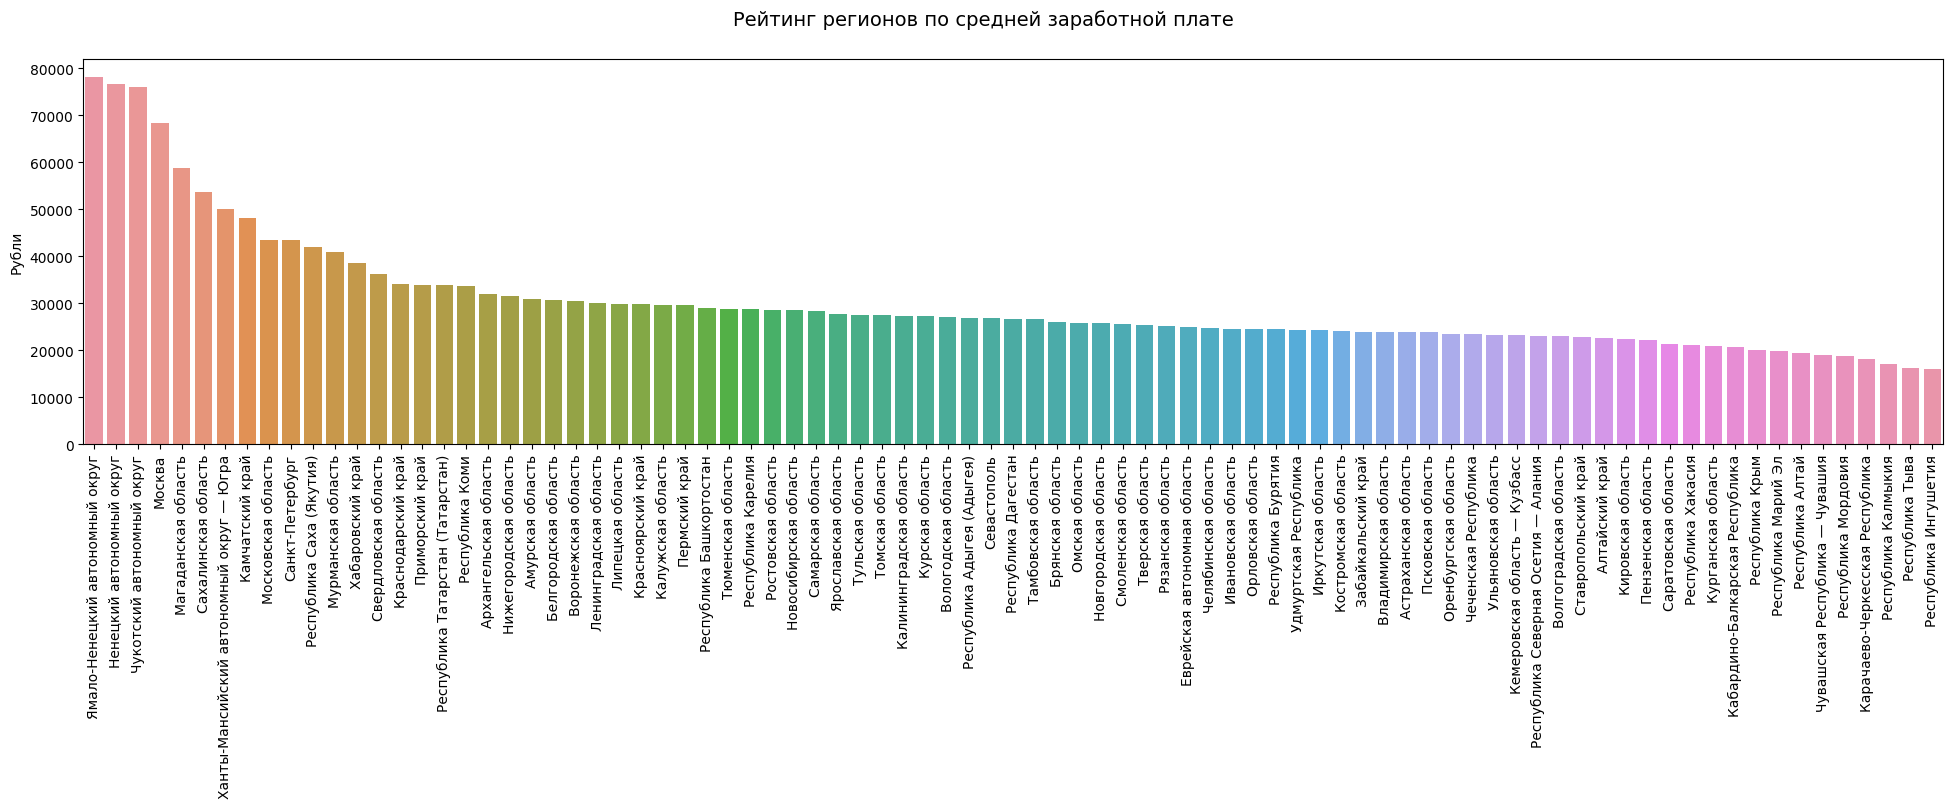

In [45]:
top_cash = df_region.sort_values(by='cash_capita', ascending=False)
fig = plt.figure(figsize=(24,5))
sns.barplot(data=top_cash, x=top_cash.index, y='cash_capita')
fig.suptitle(
    'Рейтинг регионов по средней заработной плате',
    fontsize=14)
plt.xlabel('')
plt.ylabel('Рубли')
plt.xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]),
 [Text(0, 0, 'Москва'),
  Text(1, 0, 'Сахалинская область'),
  Text(2, 0, 'Московская область'),
  Text(3, 0, 'Свердловская область'),
  Text(4, 0, 'Санкт-Петербург'),
  Text(5, 0, 'Ямало-Ненецкий автономный округ'),
  Text(6, 0, 'Тюменская область'),
  Text(7, 0, 'Ханты-Мансийский автономный округ — Югра'),
  Text(8, 0, 'Краснодарский край'),
  Text(9, 0, 'Хабаровский край'),
  Text(10, 0, 'Республика Татарстан (Татарстан)'),
  Text(11, 0, 'Воронежская область'),
  Text(12, 0, 'Республика Саха (Якутия)'),
  Text(13, 0, 'Мурманская область'),
  Text(14, 0, 'Нижегородская область'),
  Text(15, 0, 'Архангельская 

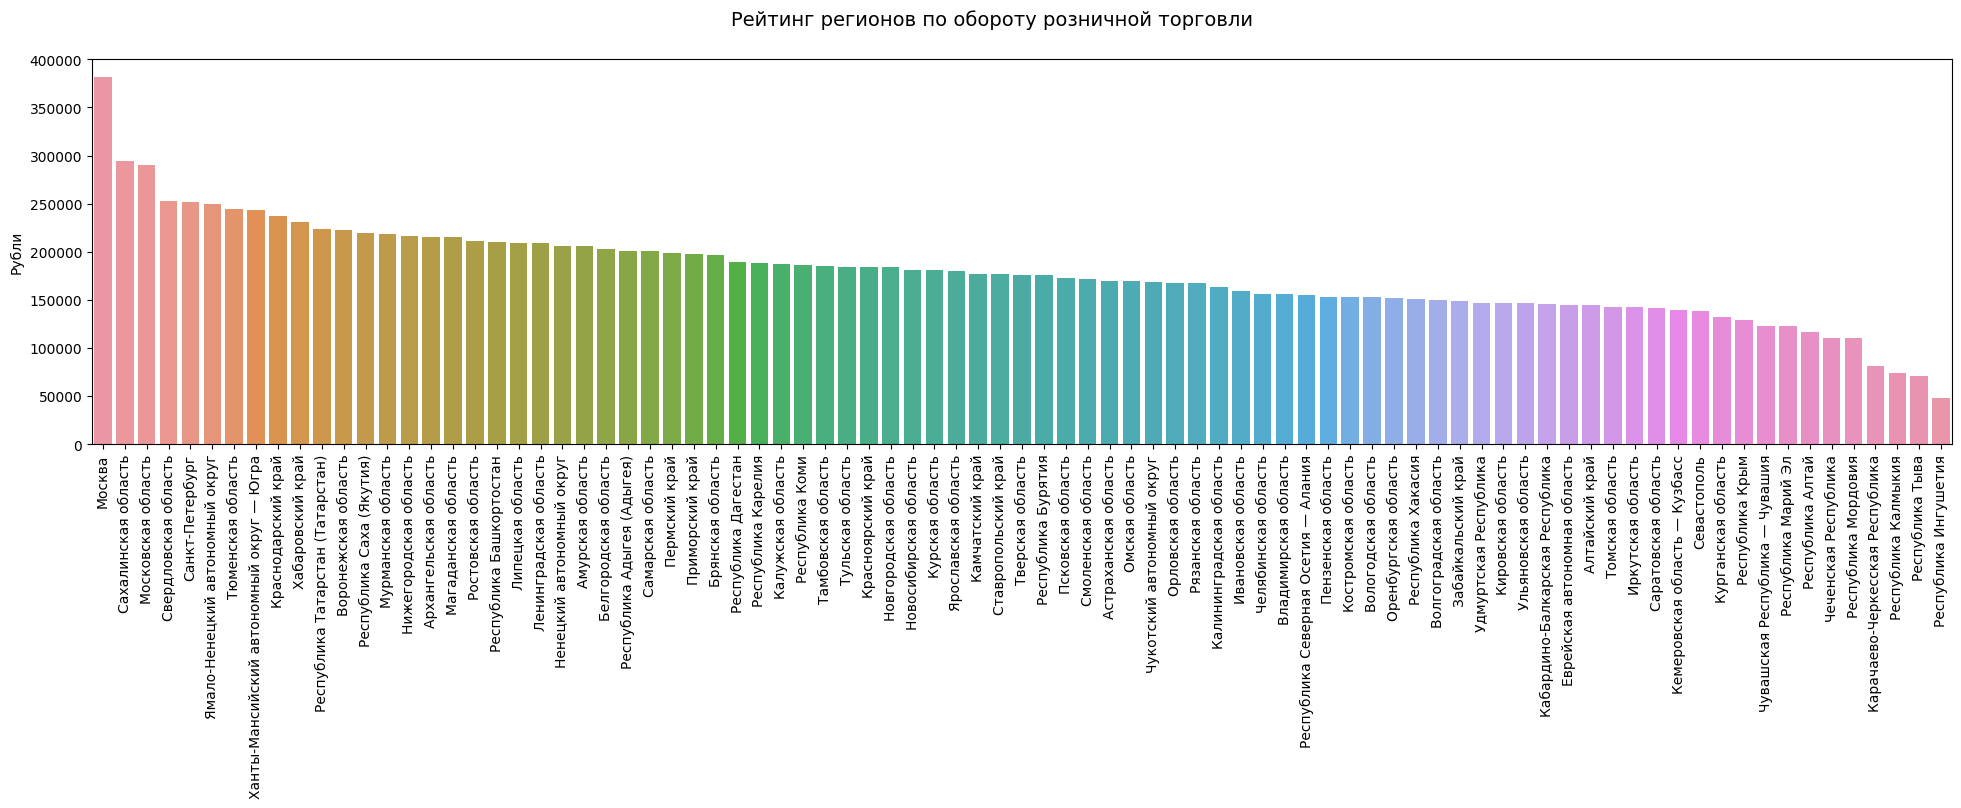

In [46]:
top_retail = df_region.sort_values(by='retail', ascending=False)
fig = plt.figure(figsize=(24,5))
sns.barplot(data=top_retail, x=top_retail.index, y='retail')
fig.suptitle(
    'Рейтинг регионов по обороту розничной торговли',
    fontsize=14)
plt.xlabel('')
plt.ylabel('Рубли')
plt.xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]),
 [Text(0, 0, 'Республика Ингушетия'),
  Text(1, 0, 'Брянская область'),
  Text(2, 0, 'Республика Дагестан'),
  Text(3, 0, 'Ненецкий автономный округ'),
  Text(4, 0, 'Республика Калмыкия'),
  Text(5, 0, 'Республика Мордовия'),
  Text(6, 0, 'Воронежская область'),
  Text(7, 0, 'Тамбовская область'),
  Text(8, 0, 'Республика Адыгея (Адыгея)'),
  Text(9, 0, 'Смоленская область'),
  Text(10, 0, 'Чеченская Республика'),
  Text(11, 0, 'Астраханская область'),
  Text(12, 0, 'Республика Крым'),
  Text(13, 0, 'Оренбургская область'),
  Text(14, 0, 'Рязанская область'),
  Text(15, 0, 'Ставропольский край'),
  Text(16, 0, 

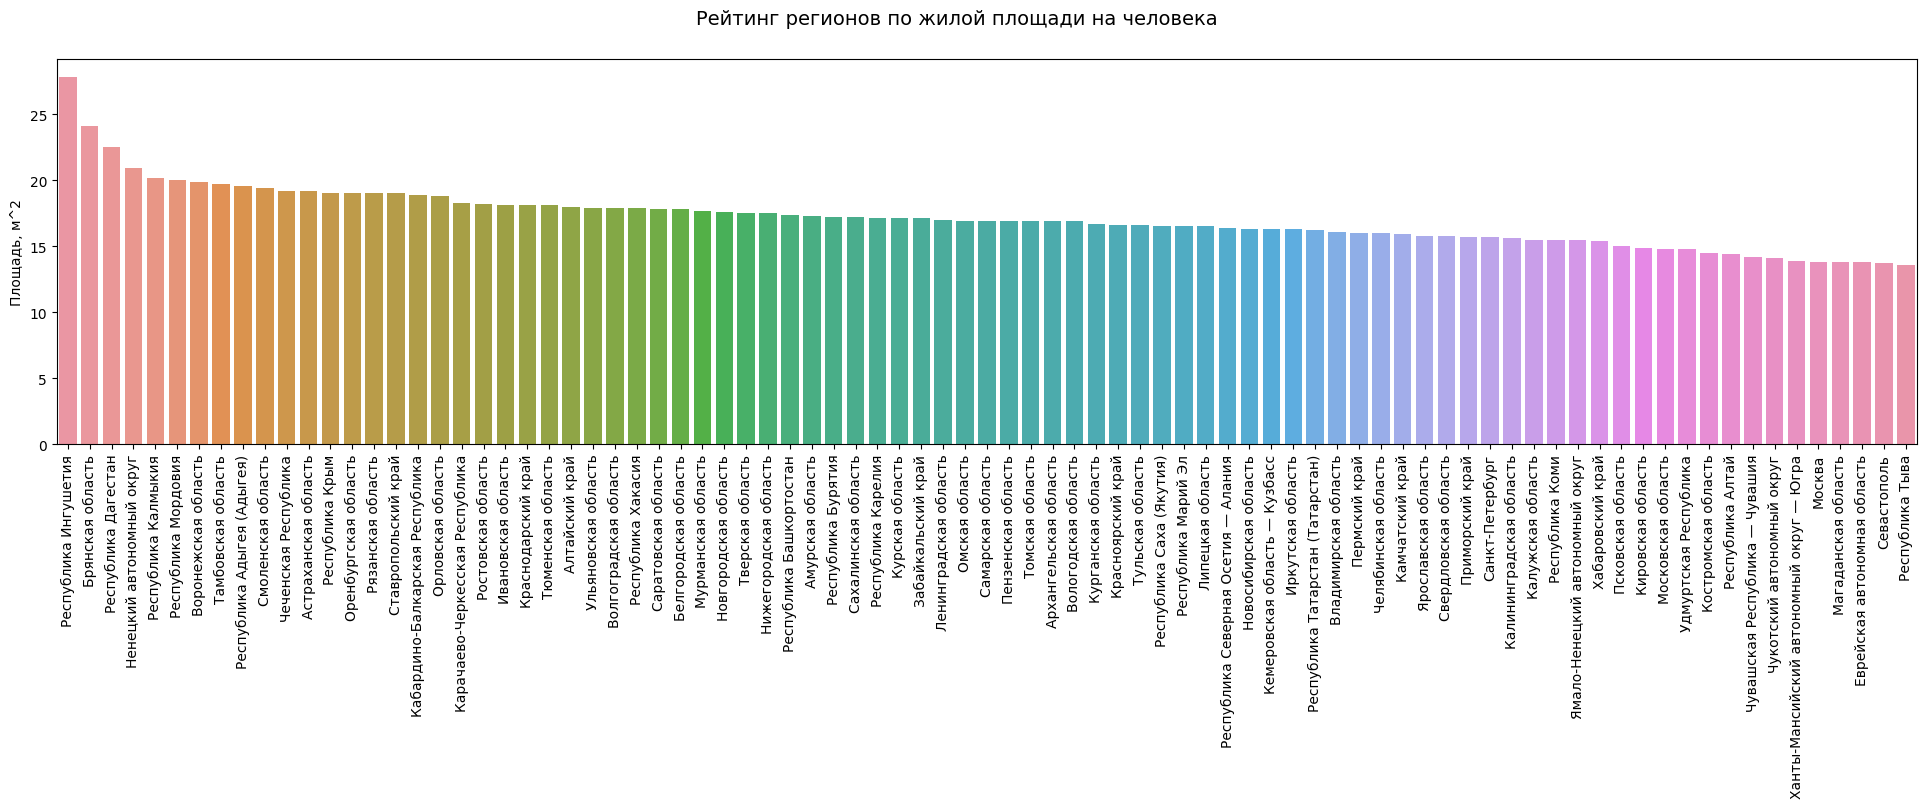

In [47]:
top_living_area = df_region.sort_values(by='living_area', ascending=False)
fig = plt.figure(figsize=(24,5))
sns.barplot(data=top_living_area, x=top_living_area.index, y='living_area')
fig.suptitle(
    'Рейтинг регионов по жилой площади на человека',
    fontsize=14)
plt.xlabel('')
plt.ylabel('Площадь, м^2')
plt.xticks(rotation = 90)

**Вывод**:
* Северные регионы занимают топ-3 по уровню зарплат, что обусловлено активной деятельностью в нефтегазовой отрасли. В то же время Москва выделяется по высокому обороту розничной торговли, а регионы с более тёплым климатом преобладают по общей площади жилья, за исключением Ненецкого автономного округа и Ямало-Ненецкого автономного округа, где схожая ситуация с Москвой.

### 2.2. Анализ корреляции

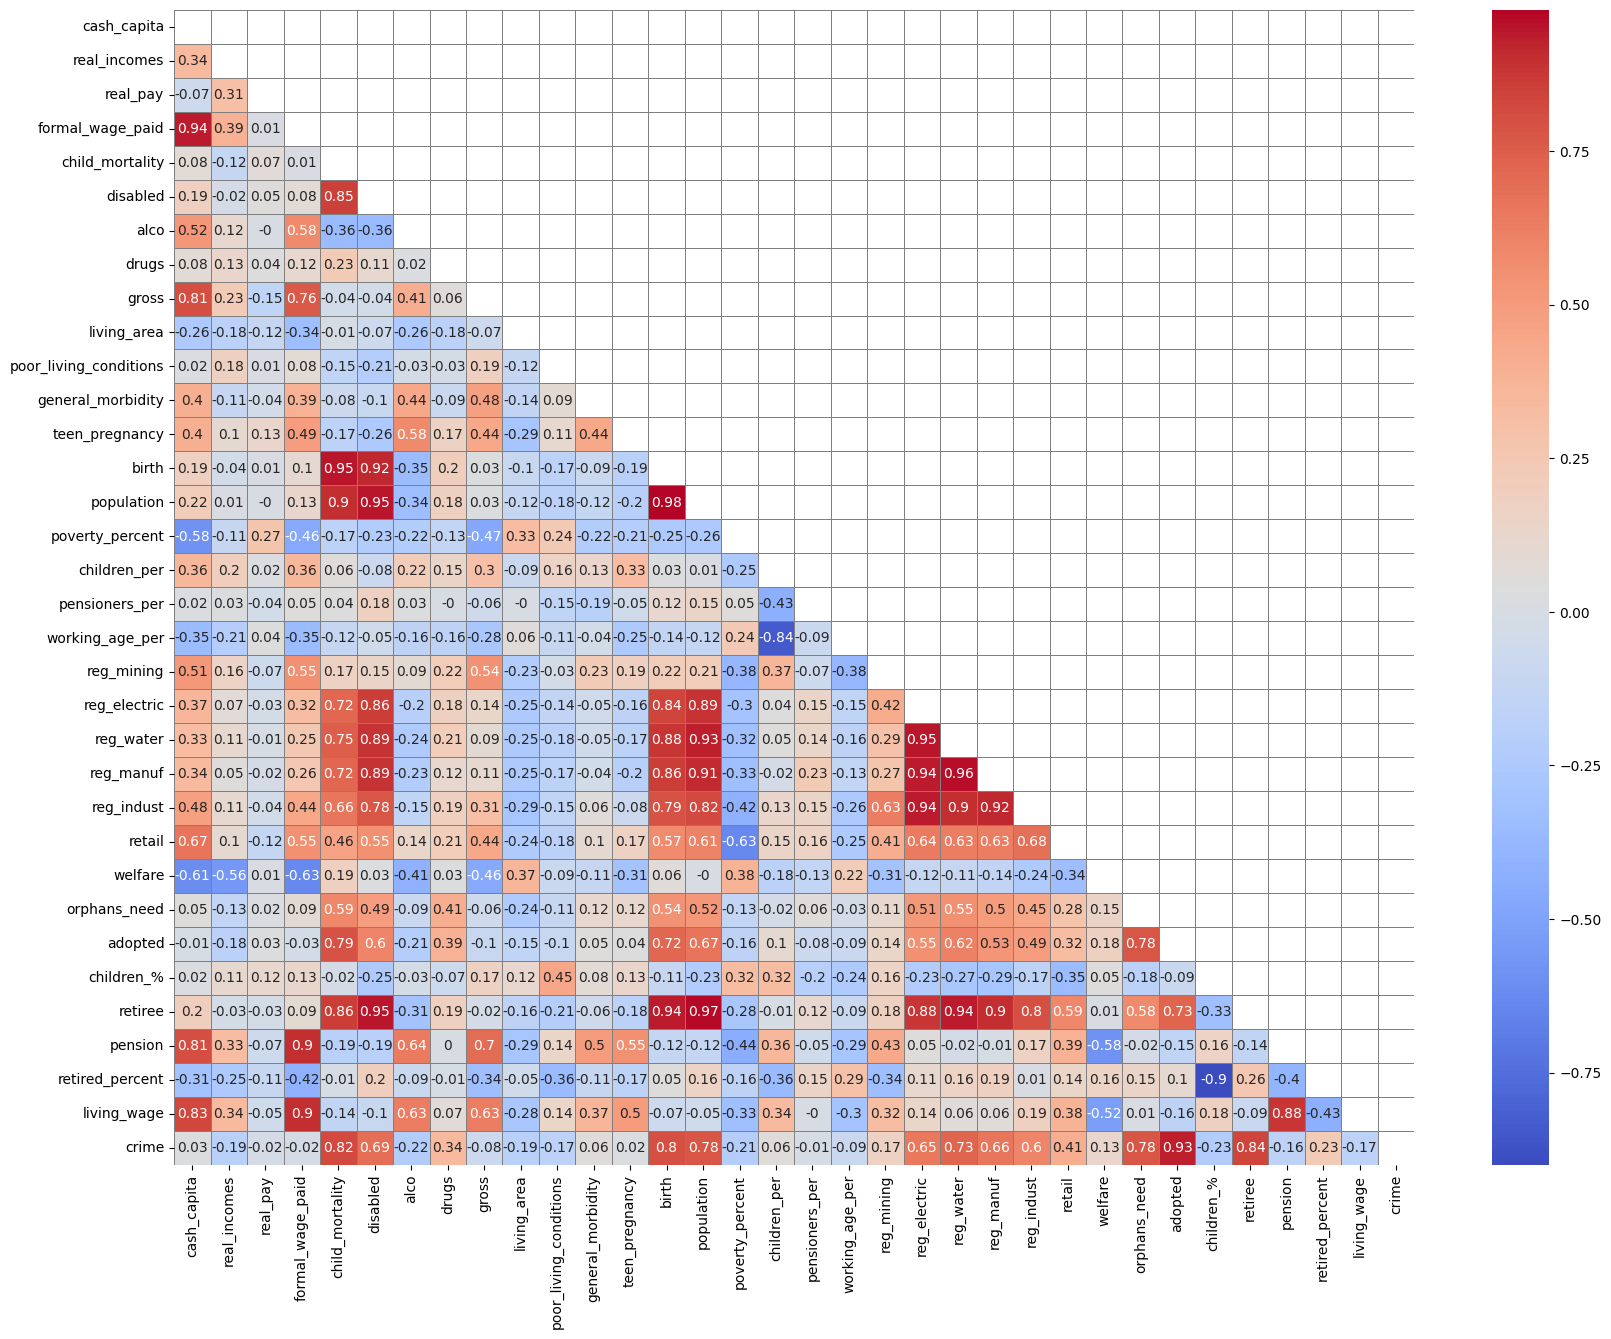

In [48]:
# Создадим тепловую карту, визуализирующую значения матрицы корреляции всех пар переменных
plt.figure(figsize=(20, 15))
corr_matrix = df_region.corr().round(decimals=2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5, mask=mask, linecolor='gray')
plt.show()

**Выводы:**
* Все показатели "Объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами" демонстрируют очень высокую корреляцию, в диапазоне от 0.9 до 0.95. В данном случае, достаточно оставить только один из этих признаков.

* Также следует отметить, что признаки из предыдущего пункта сильно коррелируют с числом пенсионеров, количеством инвалидов и рождаемостью, причем все эти корреляции превышают значение 0.9. Возможно, это свидетельствует о важной взаимосвязи между этими показателями.

* Интересно, что наблюдается сильная обратная корреляция между количеством детей и взрослых малоимущих. Возможно, это указывает на то, что в бедных регионах семьи реже имеют большое количество детей.

* Также стоит отметить, что высокая обратная корреляция наблюдается между оборотом розничной торговли и процентом населения, находящимся за чертой бедности. Также уровень среднемесячного дохода имеет сильную обратную корреляцию с процентом населения, проживающего за чертой бедности. Эти данные могут свидетельствовать о том, что бедные регионы имеют низкий уровень розничной торговли и меньший средний доход.

In [49]:
df_region['cash_capita_norm'] = df_region['cash_capita'] / df_region['living_wage']
df_region['formal_wage_norm'] = df_region['formal_wage_paid'] / df_region['living_wage']
df_region['retail_norm'] = df_region['retail'] / df_region['living_wage']

df_region.drop(columns=['cash_capita', 'formal_wage_paid', 'retail'], axis=1, inplace=True)

### 2.3 Анализ распределения признаков и связи признаков

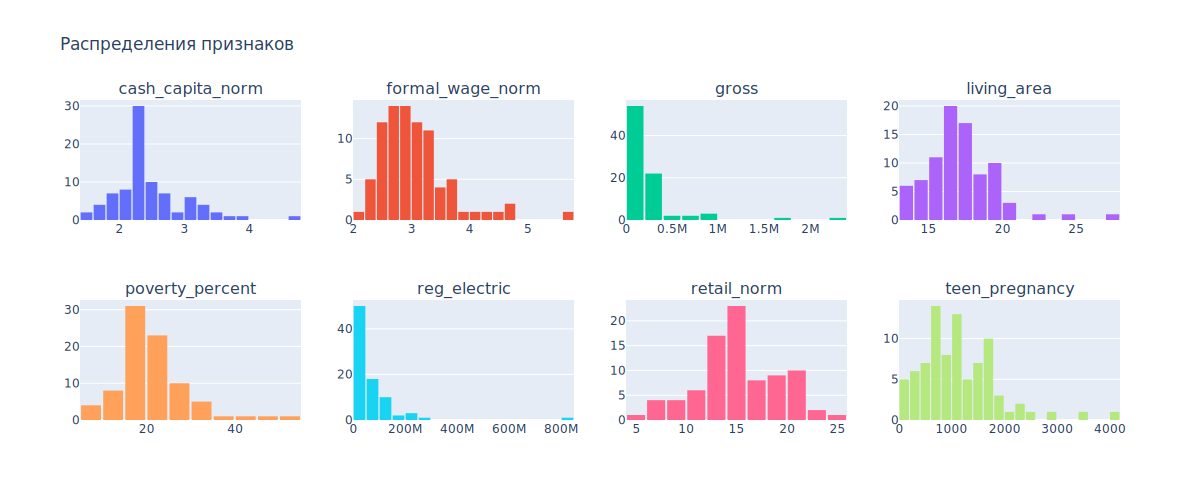

In [50]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

cols=['cash_capita_norm','formal_wage_norm','gross','living_area',
      'poverty_percent','reg_electric','retail_norm', 'teen_pregnancy']

# Создайте объект subplots
fig = make_subplots(rows=2, cols=4, subplot_titles=cols)

# Создайте гистограммы и добавьте их к объекту fig
for i, col in enumerate(cols):
    row = 1 if i < 4 else 2
    col_num = i % 4 + 1
    fig.add_trace(go.Histogram(x=df_region[col], nbinsx=20), row=row, col=col_num)

# Обновите макет и отобразите график
fig.update_layout(title='Распределения признаков',
                  showlegend=False, width=1200, height=500)
fig.layout.bargap = 0.1
fig.show('svg')

Признаки 'gross' и 'reg_electic' следует перевести в логарифмическую шкалу.

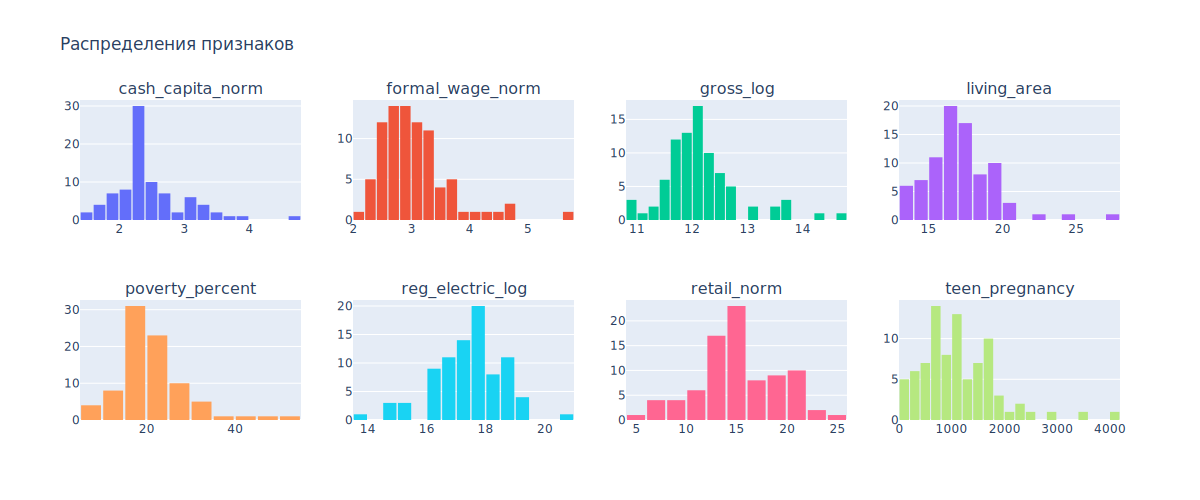

In [51]:
df_region['gross_log'] = np.log(df_region['gross'])
df_region['reg_electric_log'] = np.log(df_region['reg_electric'])
df_region.drop(columns=['gross', 'reg_electric'],axis=1, inplace=True)

cols=['cash_capita_norm','formal_wage_norm','gross_log','living_area',
      'poverty_percent','reg_electric_log','retail_norm', 'teen_pregnancy']

# Создайте объект subplots
fig = make_subplots(rows=2, cols=4, subplot_titles=cols)

# Создайте гистограммы и добавьте их к объекту fig
for i, col in enumerate(cols):
    row = 1 if i < 4 else 2
    col_num = i % 4 + 1
    fig.add_trace(go.Histogram(x=df_region[col], nbinsx=20), row=row, col=col_num)

# Обновите макет и отобразите график
fig.update_layout(title='Распределения признаков',
                  showlegend=False, width=1200, height=500)
fig.layout.bargap = 0.1
fig.show('svg')

In [52]:
cols=['cash_capita_norm','formal_wage_norm','gross_log','living_area',
      'poverty_percent','reg_electric_log','retail_norm', 'teen_pregnancy']

df_region = df_region[cols].copy()

In [53]:
for col in df_region.columns:
    _, p = shapiro(df_region[col])
    print(f'{col}:   p-value = {p:.3f}')

cash_capita_norm:   p-value = 0.000
formal_wage_norm:   p-value = 0.000
gross_log:   p-value = 0.000
living_area:   p-value = 0.000
poverty_percent:   p-value = 0.000
reg_electric_log:   p-value = 0.342
retail_norm:   p-value = 0.468
teen_pregnancy:   p-value = 0.000


Распределение данных не соответствует нормальному, и наибольшая степень приближения к нормальному распределению наблюдается на графиках "reg_electric_log" и "retail_norm". В силу отсутствия нормальности в распределении данных, решено применить ранговую корреляцию Спирмена и Кендалла для более точной оценки связей между переменными.

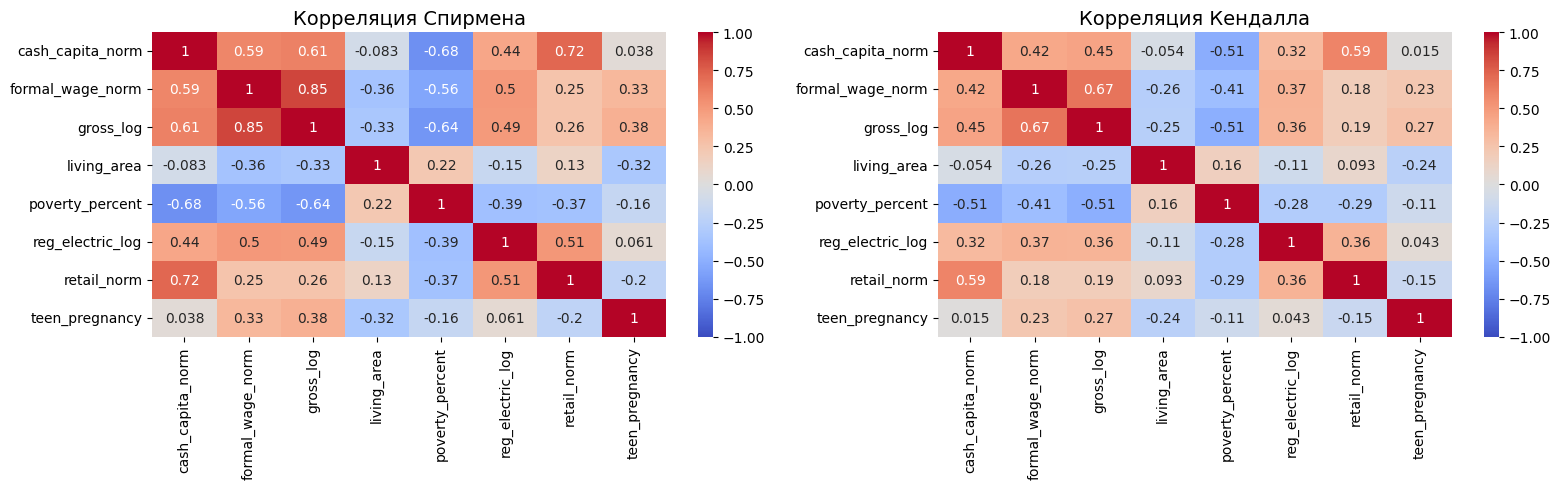

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.heatmap(df_region.corr(method='spearman'), 
            annot=True, cmap='coolwarm', vmin=-1, ax=ax[0])
sns.heatmap(df_region.corr(method='kendall'), 
            annot=True, cmap='coolwarm', vmin=-1, ax=ax[1])
ax[0].set_title('Корреляция Спирмена', fontsize=14)
ax[1].set_title('Корреляция Кендалла', fontsize=14)
plt.tight_layout()

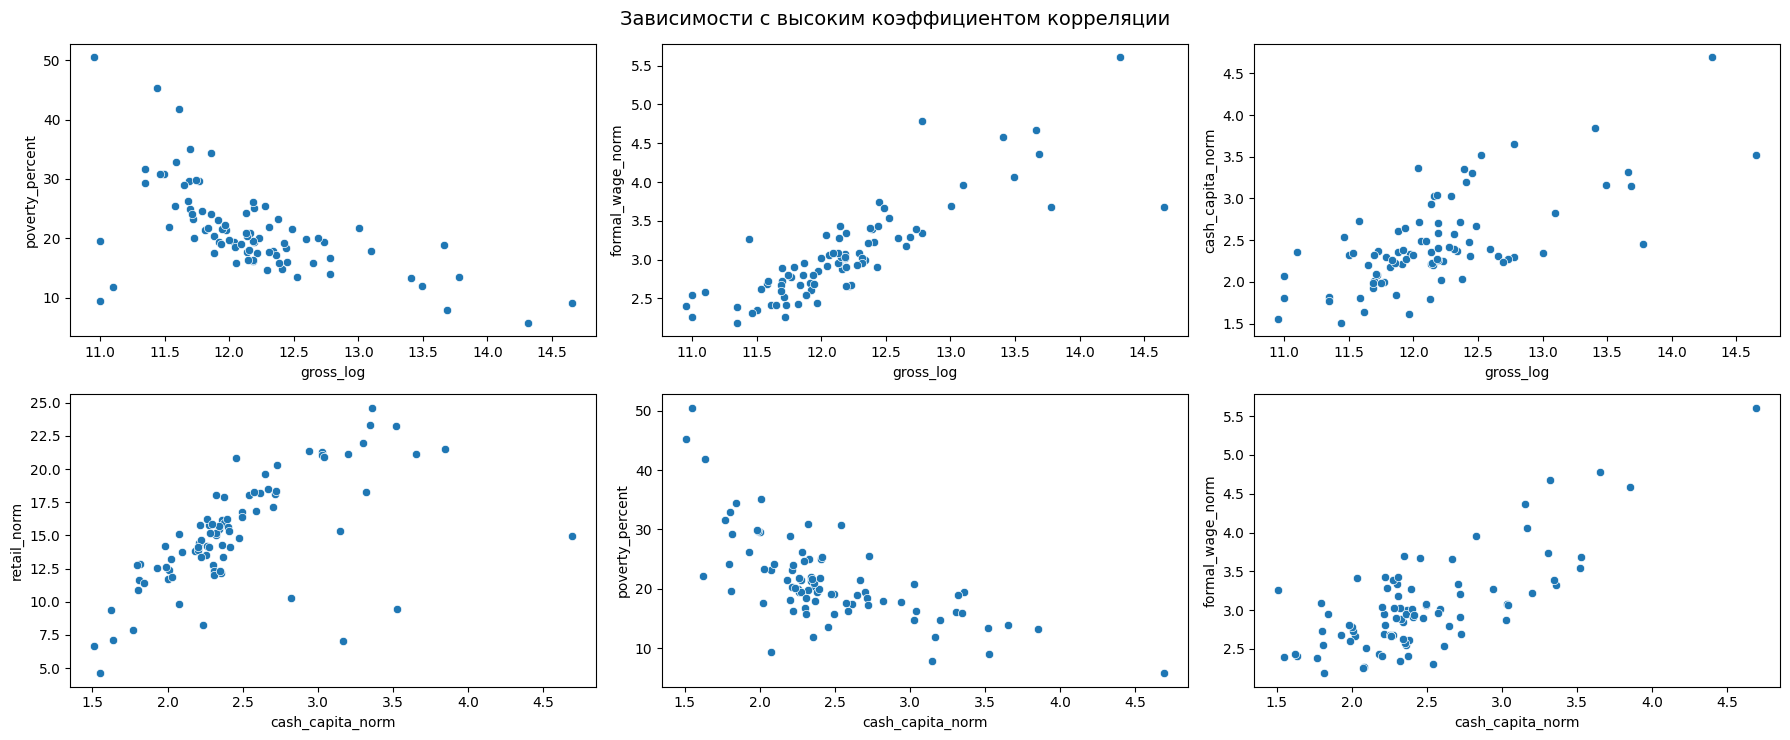

In [55]:
# Создайте сетку графиков
fig, axes = plt.subplots(2, 3, figsize=(18, 7.5))

# Список пар столбцов для создания scatterplot
pairs = [('gross_log', 'poverty_percent'),
         ('gross_log', 'formal_wage_norm'),
         ('gross_log', 'cash_capita_norm'),
         ('cash_capita_norm', 'retail_norm'),
         ('cash_capita_norm', 'poverty_percent'),
         ('cash_capita_norm', 'formal_wage_norm')]

# Создайте графики в цикле
for i, pair in enumerate(pairs):
    row = i // 3
    col = i % 3
    sns.scatterplot(data=df_region, x=pair[0], y=pair[1], ax=axes[row, col])

# Установите общее заголовок
plt.suptitle('Зависимости с высоким коэффициентом корреляции', fontsize=14)

# Уточните макет
plt.tight_layout()

# Показать графики
plt.show()

**Вывод**: 
* Имеется только одна очень высокая корреляция между 'gross_log' и 'formal_wage_norm', которая составляет 0.82 (по Пирсону) или 0.66 (по Кендаллу). Остальные признаки не демонстрируют корреляции, превышающей 0.72. Исходя из этой информации, можно заключить, что не требуется удаление признаков, так как корреляции между ними не являются чрезмерно высокими и не создают проблем для анализа данных.

### 2.4. Анализ на наличие выбросов

При анализе распределения данных выявдены выбросы и нам необходимо понять природу выбросов и обработать их, если необходимо

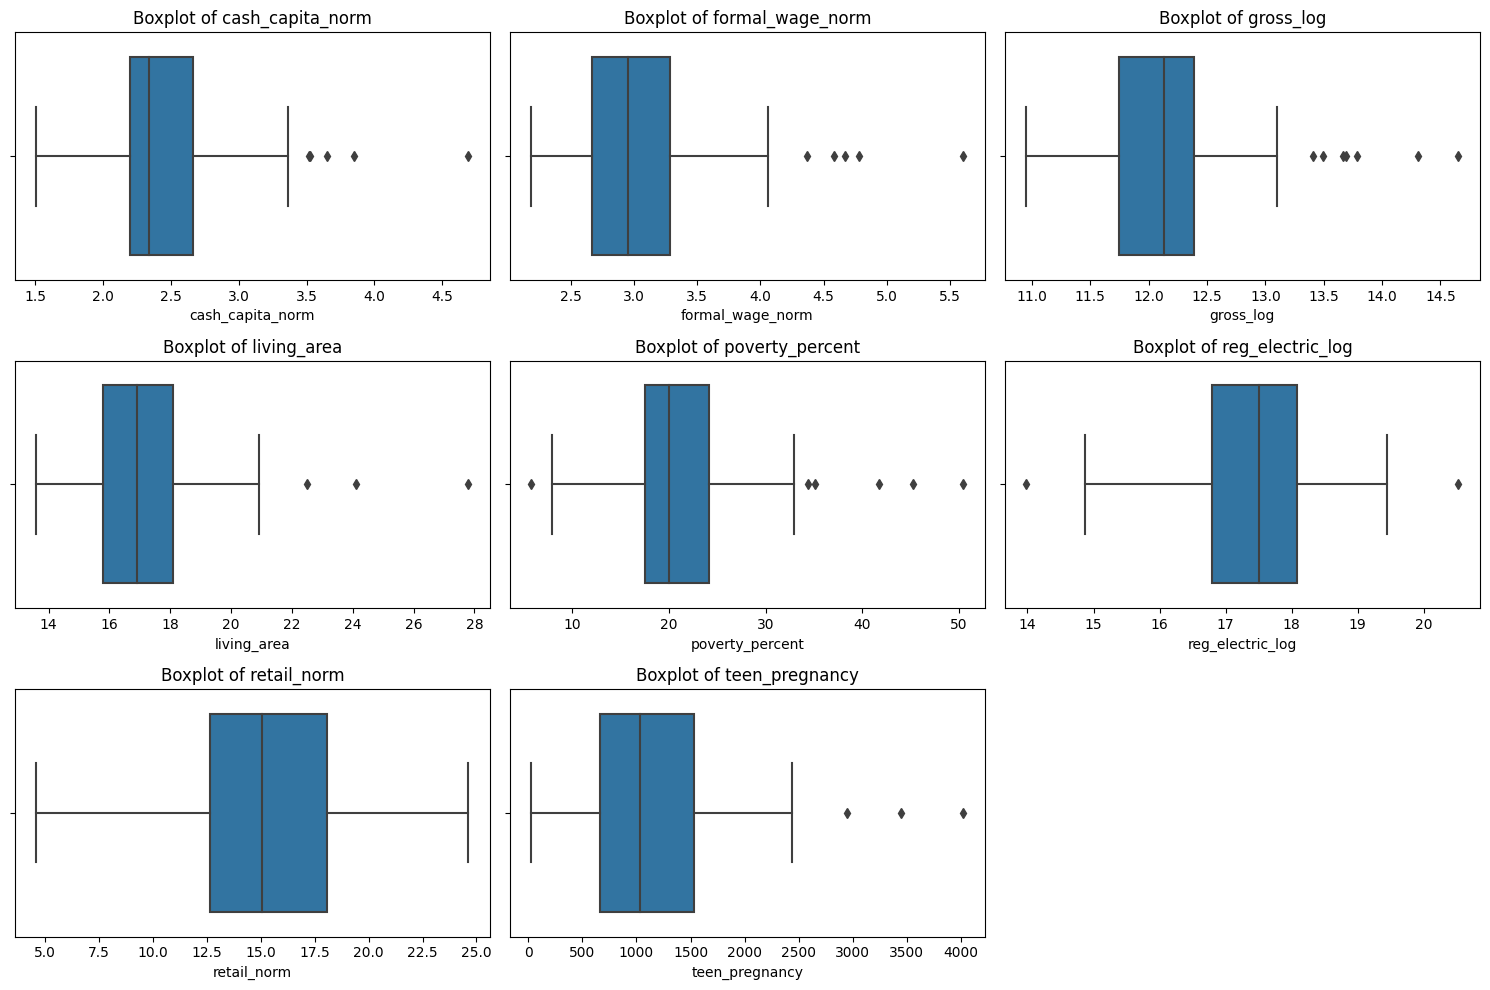

In [56]:
# Plotting box plots for key indicators to visualize outliers
cols = ['cash_capita_norm','formal_wage_norm','gross_log','living_area',
      'poverty_percent','reg_electric_log','retail_norm', 'teen_pregnancy']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df_region, x=feature)
    plt.title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

In [57]:
outliers_info = {}

for feature in cols:
    Q1 = df_region[feature].quantile(0.25)
    Q3 = df_region[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Finding indexes of outliers for each feature
    outlier_indexes = df_region[(df_region[feature] < lower_bound) | (df_region[feature] > upper_bound)].index.tolist()

    # Storing the outlier indexes in the dictionary
    outliers_info[feature] = outlier_indexes

# Displaying the outliers for each key indicator
outliers_info

{'cash_capita_norm': ['Москва',
  'Ненецкий автономный округ',
  'Санкт-Петербург',
  'Республика Татарстан (Татарстан)',
  'Ямало-Ненецкий автономный округ'],
 'formal_wage_norm': ['Москва',
  'Санкт-Петербург',
  'Ханты-Мансийский автономный округ — Югра',
  'Ямало-Ненецкий автономный округ',
  'Сахалинская область'],
 'gross_log': ['Москва',
  'Ненецкий автономный округ',
  'Ханты-Мансийский автономный округ — Югра',
  'Ямало-Ненецкий автономный округ',
  'Тюменская область',
  'Сахалинская область',
  'Чукотский автономный округ'],
 'living_area': ['Брянская область',
  'Республика Дагестан',
  'Республика Ингушетия'],
 'poverty_percent': ['Республика Калмыкия',
  'Республика Ингушетия',
  'Республика Марий Эл',
  'Ямало-Ненецкий автономный округ',
  'Республика Тыва',
  'Забайкальский край'],
 'reg_electric_log': ['Москва', 'Республика Ингушетия'],
 'retail_norm': [],
 'teen_pregnancy': ['Ненецкий автономный округ',
  'Магаданская область',
  'Сахалинская область']}

## 3. Кластеризация

Масштабируем признаки методом MinMaxScaler:

In [58]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df_region)

### 3.1 Базовая модель K-Means

Определим число кластеров и воспользуемся методом k-means в качестве базовой модели.

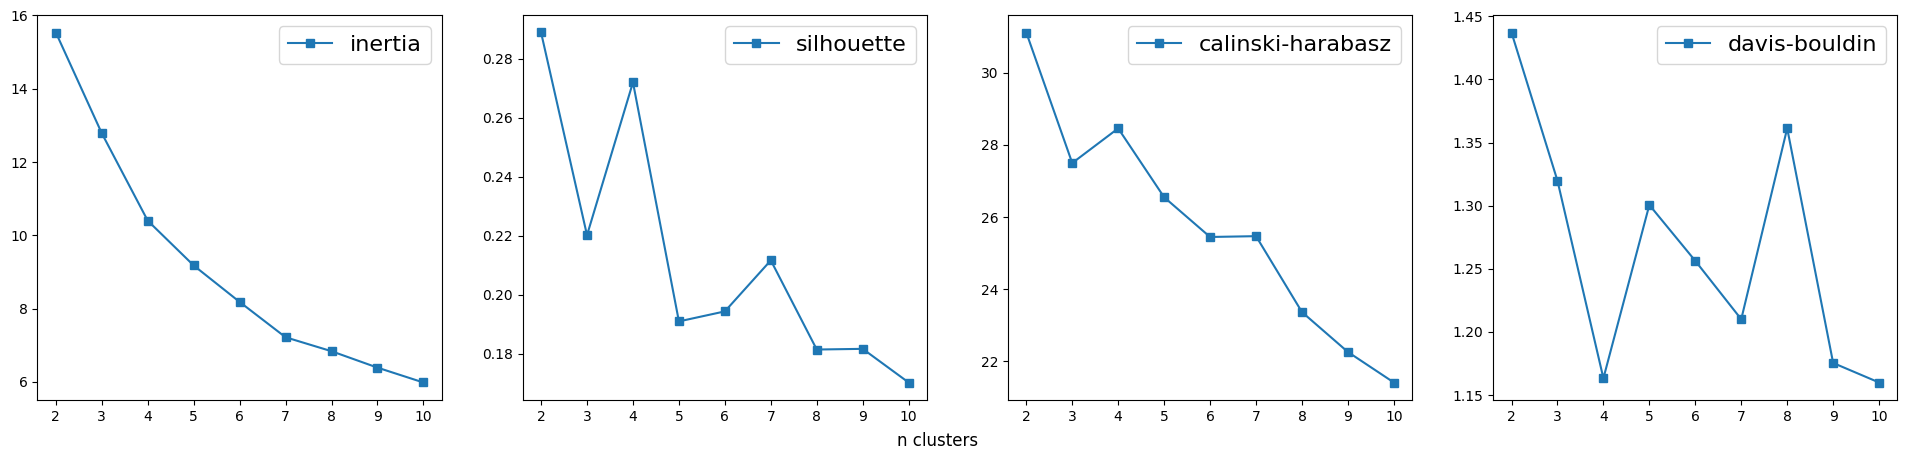

In [59]:
def plot_metrics(X):
    """Построение графиков кластеризации в зависимости от количества кластеров"""
    inertia = []
    silhouette = []
    calinski_harabasz = []
    davis_bouldin = []
    
    for n_cl in range(2, 11):
        kmeans = cluster.KMeans(n_clusters=n_cl, random_state=42)
        kmeans.fit(X)
    
        inertia.append(kmeans.inertia_)
        silhouette.append(metrics.silhouette_score(
            X, kmeans.labels_))
        calinski_harabasz.append(metrics.calinski_harabasz_score(
            X, kmeans.labels_))
        davis_bouldin.append(metrics.davies_bouldin_score(
            X, kmeans.labels_))
        
    fig, ax = plt.subplots(1, 4, figsize=(24,5))
    
    ax[0].plot(range(2, 11), inertia, 's-', label='inertia')
    ax[1].plot(range(2, 11), silhouette, 's-', label='silhouette')
    ax[2].plot(range(2, 11), calinski_harabasz, 's-', label='calinski-harabasz')
    ax[3].plot(range(2, 11), davis_bouldin, 's-', label='davis-bouldin')
    ax[0].legend(prop={'size': 16})
    ax[1].legend(prop={'size': 16})
    ax[2].legend(prop={'size': 16})
    ax[3].legend(prop={'size': 16});
    fig.supxlabel('n clusters')
    
        
plot_metrics(X)

С учетом методов, оптимальным числом кластеров будет 4. Для визуализации результатов кластеризации мы воспользуемся t-SNE преобразованием для проецирования пятимерного признакового пространства на двумерную плоскость. После этого мы выведем значения метрик качества кластеризации.

Silhouette: 0.272
Calinski-Harabatz: 28.458
Davis-Bouldin: 1.163


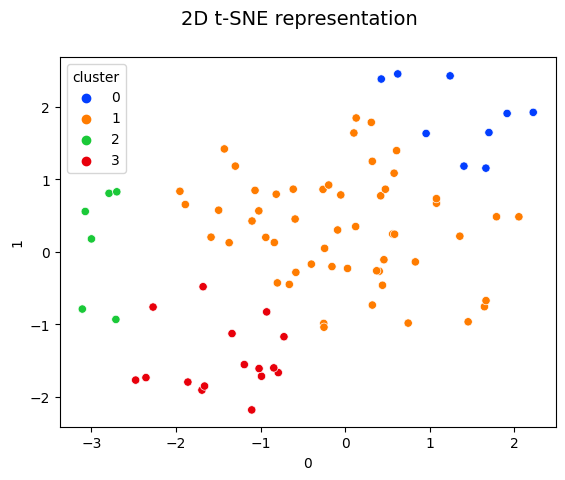

In [60]:
def plot_results(X, labels):
    "Построение 2D t-SNE представление и вычисление метрик"
    tsne = TSNE(n_components=2, perplexity=50, init='pca',
                learning_rate='auto', random_state=42)
    df_tsne = pd.DataFrame(tsne.fit_transform(X))
    df_tsne['cluster'] = labels
    fig = plt.figure()
    sns.scatterplot(x=df_tsne[0], y=df_tsne[1],
                    hue=df_tsne['cluster'], palette='bright')
    fig.suptitle('2D t-SNE representation', fontsize=14);

    print('Silhouette: {:.3f}'.format(
        metrics.silhouette_score(X, labels)))
    print('Calinski-Harabatz: {:.3f}'.format(
        metrics.calinski_harabasz_score(X, labels)))
    print('Davis-Bouldin: {:.3f}'.format(
        metrics.davies_bouldin_score(X, labels)))
        

kmeans = cluster.KMeans(n_clusters=4, random_state=42)
bm_labels = kmeans.fit_predict(X)
plot_results(X, bm_labels)

#### 3.1.1 Понижение размерности

Число главных компонент: 5


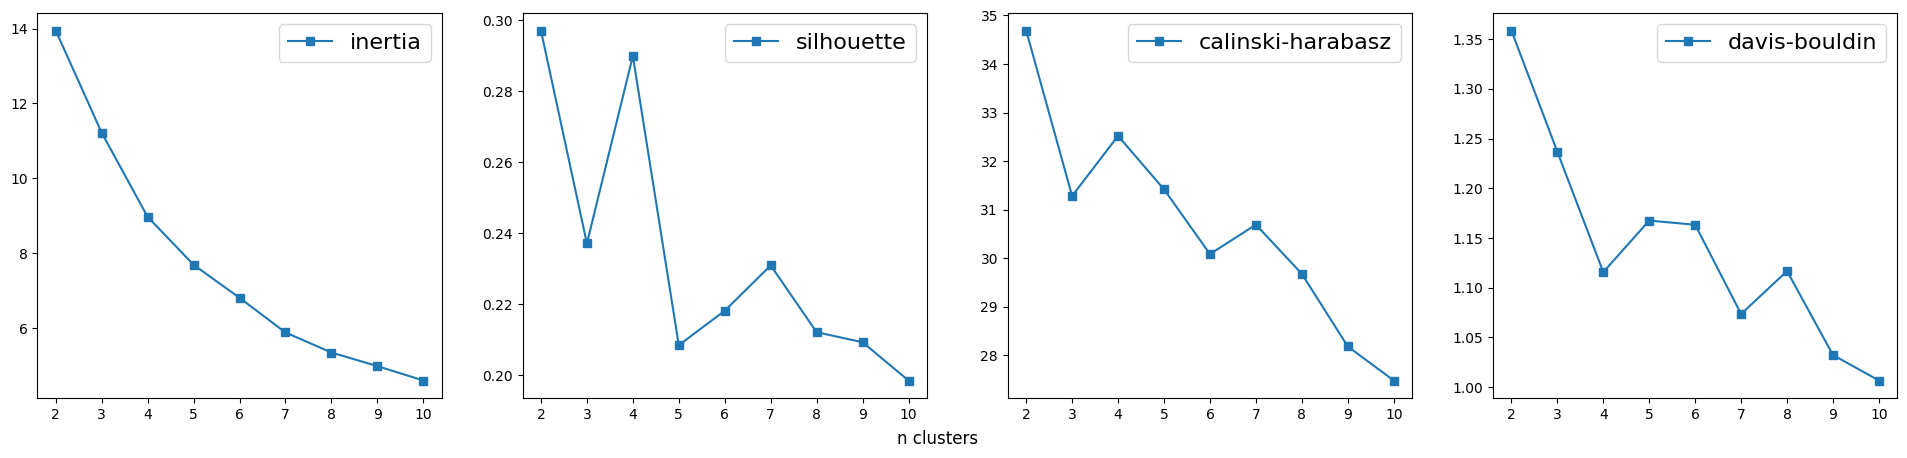

In [61]:
pca = PCA(n_components=0.9)  # 90% of explained dispersion
X_pca = pca.fit_transform(X)
print(f'Число главных компонент: {pca.n_components_}')

plot_metrics(X_pca)

Silhouette: 0.290
Calinski-Harabatz: 32.520
Davis-Bouldin: 1.116
Rand score (сравнение с базовой моделью): 0.982633


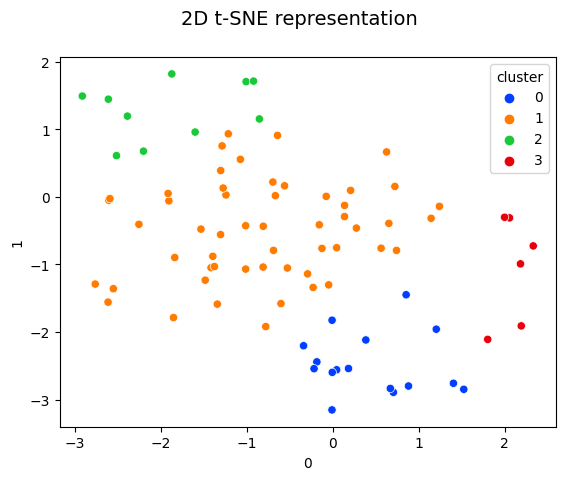

In [62]:
kmeans_pca = cluster.KMeans(n_clusters=4, random_state=42)
kmeans_pca.fit_predict(X_pca)
plot_results(X_pca, kmeans_pca.labels_)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(bm_labels, kmeans_pca.labels_)))

**Вывод**:
* Исходя из анализа метода локтя и значения силуэта, мы приходим к выводу, что оптимальным числом кластеров является 4. Эти метрики свидетельствуют о лучшем качестве кластеризации по сравнению с базовой моделью.

In [63]:
fig = px.scatter_3d(
    x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
    title='Кластеры в пространстве трех главных компонент (PCA)',
    color=kmeans_pca.labels_, width=650, height=400)
fig.update_traces(marker={'size':3}, marker_line_width=0.5)
fig.show()

### 3.2 Тестирование алгортимов, отличных от базовых

Используем данные, которые были подвергнуты PCA-преобразованию, их представляет массив X_pca. Мы устанавливаем количество кластеров на уровне четырех.

Silhouette: 0.335
Calinski-Harabatz: 30.417
Davis-Bouldin: 0.956
Rand score (сравнение с базовой моделью): 0.853221


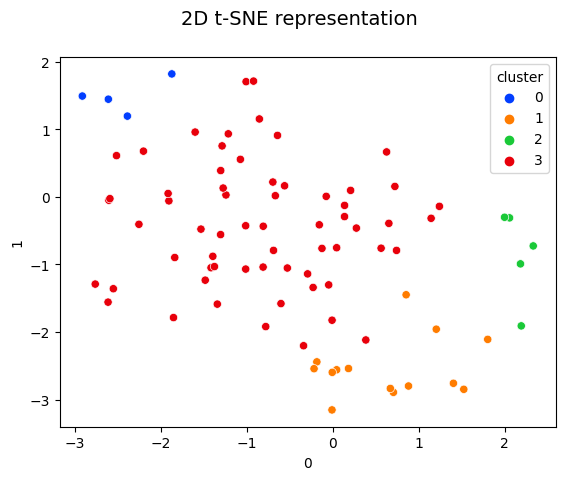

In [64]:
# Гауссова смесь, наилучший вариант: covariance_type='tied'
gmix = GaussianMixture(
    n_components=4, random_state=42, covariance_type='tied')
labels = gmix.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(bm_labels, labels)))

Silhouette: 0.200
Calinski-Harabatz: 27.183
Davis-Bouldin: 1.348
Rand score (сравнение с базовой моделью): 0.778151


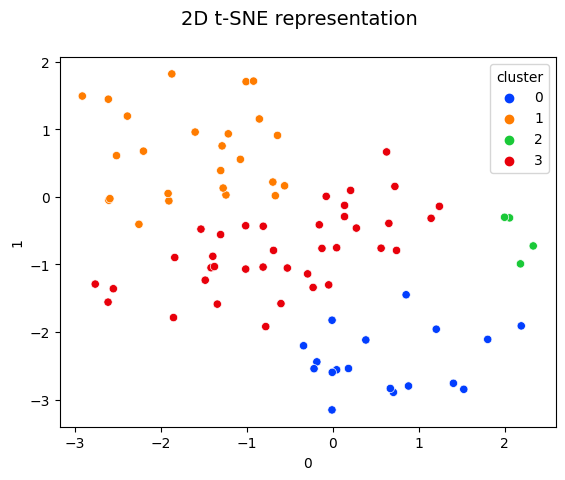

In [65]:
# Агломеративная кластеризация, наилучший вариант: linkage='ward'
tree_like = cluster.AgglomerativeClustering(n_clusters=4, linkage='ward')
labels = tree_like.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(bm_labels, labels)))

Silhouette: 0.184
Calinski-Harabatz: 25.052
Davis-Bouldin: 0.832
Rand score (сравнение с базовой моделью): 0.633613


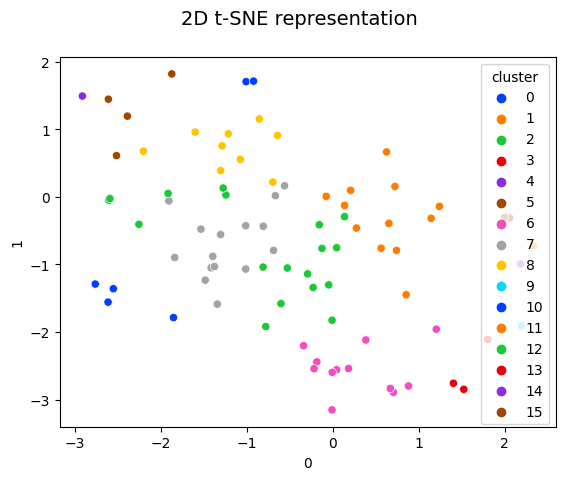

In [66]:
# Метод распространения близости
aff_prop = cluster.AffinityPropagation(damping=0.9, random_state=42)
labels = aff_prop.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(bm_labels, labels)))

Silhouette: 0.333
Calinski-Harabatz: 28.863
Davis-Bouldin: 0.867
Rand score (сравнение с базовой моделью): 0.828011


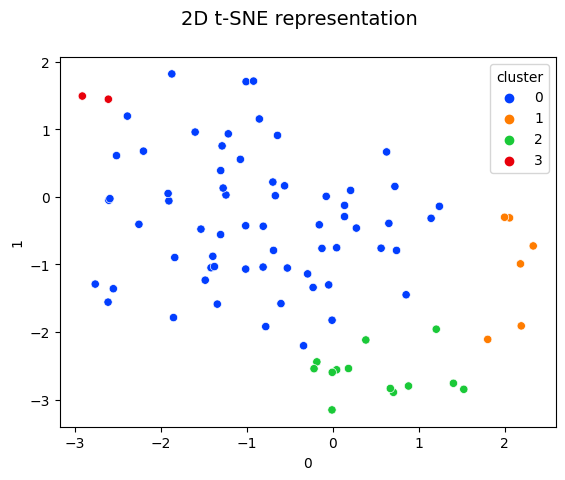

In [67]:
spectral = cluster.SpectralClustering(n_clusters=4)
labels = spectral.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
      .format(metrics.rand_score(bm_labels, labels)))

**Вывод**
* Гауссовская смесь выделяется наилучшим значением коэффициента силуэта, в то время как метод k-means на признаках, полученных после применения PCA, демонстрирует наивысший коэффициент Calinski-Harabatz. Метод распространения близости достигает наилучшего значения коэффициента Davis-Bouldin.

* Сравнивая индексы Рэнда с базовой моделью, можно заметить, что они остаются на высоком уровне. Это указывает на стабильность общей структуры распределения объектов по кластерам при использовании различных алгоритмов.

* Нет явного однозначного лидера среди методов, поэтому мы принимаем решение остановиться на использовании Гауссовской смеси как наиболее предпочтительного метода.

In [68]:
# Гауссова смесь, наилучший вариант: covariance_type='tied'
gmix = GaussianMixture(
    n_components=4, random_state=42, covariance_type='tied')
labels_gmix = gmix.fit_predict(X_pca)
result['cluster'] = labels_gmix

# Упорядочим нумерацию кластеров 
result['cluster'] = result['cluster'].replace({2:0, 0:1, 3:2, 1:3})
result.to_csv('data/regions_cluster.csv')
result['cluster'].to_csv('data/labels.csv')

fig = px.scatter_3d(
    x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
    title='Кластеры в пространстве трех главных компонент (PCA)',
    color=result['cluster'], width=650, height=400)
fig.update_traces(marker={'size':3}, marker_line_width=0.5)
fig.show()

In [69]:
result

,cash_capita,real_incomes,real_pay,formal_wage_paid,child_mortality,disabled,alco,drugs,gross,living_area,...,welfare,orphans_need,adopted,children_%,retiree,pension,retired_percent,living_wage,crime,cluster
region,,,,,,,,,,,,,,,,,,,,,
Белгородская область,30692.500000,-0.026988,0.226147,30920.333333,139.21875,2.155028e+06,71.728571,4.007143,244680.468,17.8,...,14.166667,215.250,249.375,18.310386,414591.142857,13824.707143,27.214286,9593.0,4414.243590,3
Брянская область,26015.500000,-0.066900,0.163988,26399.166667,154.40625,1.131007e+06,157.671429,13.242857,123532.820,24.1,...,23.466667,350.500,322.000,18.620793,291857.571429,13599.815714,27.428571,10950.0,5347.576923,2
Владимирская область,23908.333333,-0.104430,0.204056,29127.166667,142.78125,1.318312e+06,113.428571,9.828571,149340.336,16.1,...,22.150000,408.500,485.625,17.989794,396645.142857,13789.344286,28.914286,10808.0,6038.564103,2
Воронежская область,30422.833333,-0.120706,0.181671,30077.000000,216.31250,2.291732e+06,121.750000,17.414286,168933.316,19.9,...,19.150000,207.375,644.500,17.079093,627980.714286,13067.284286,28.485714,9053.0,8375.846154,3
Ивановская область,24567.833333,-0.097117,0.095723,24856.666667,116.25000,8.287487e+05,143.871429,10.007143,98471.104,18.1,...,25.483333,402.625,282.500,17.835351,281335.000000,13336.671429,28.457143,10581.0,4168.115385,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Амурская область,30861.500000,-0.027404,0.265856,41014.333333,174.84375,6.893337e+05,117.421429,25.092857,196049.812,17.3,...,23.816667,744.500,582.375,22.211413,187448.428571,14376.510000,22.514286,13530.0,6080.730769,2
Магаданская область,58826.833333,0.078412,0.266546,82467.500000,26.43750,5.328867e+04,317.800000,18.814286,488520.872,13.8,...,11.666667,230.250,59.125,20.632775,40223.000000,21487.675714,21.014286,20830.0,1013.858974,0
Сахалинская область,53568.333333,0.052270,0.251547,75366.833333,68.25000,2.282195e+05,285.678571,28.271429,860733.340,17.2,...,12.950000,299.000,263.625,21.016274,145305.571429,18548.972857,22.971429,16130.0,3137.628205,0


На основе подготовленного набора данных, охватывающего различные регионы России, были выбраны критерии для их группировки в кластеры с аналогичными характеристиками, которые определяются социально-экономическим благополучием субъектов федерации. Для этого были разработаны рейтинги регионов на основе выбранных параметров. В рамках анализа данных, были изучены распределения выбранных критериев и взаимосвязи между ними. После этого был выполнен отбор критериев и проведены необходимые преобразования данных.

Итоговый набор данных для проведения кластеризации включает в себя 8 независимых индикаторов:

Заработная плата, нормализованная на прожиточный минимум региона.
Среднемесячный денежный доход на человека, нормализованный на прожиточный минимум региона.
Валовый региональный продукт на душу населения.
Жилая площадь на душу населения.
Процент населения, находящегося за чертой бедности.
Показатель обеспечения электроэнергией, газом и паром.
Оборот розничной торговли на душу населения, нормализованный на прожиточный минимум региона.
Подростковая беременность.
Мы использовали различные внутренние метрики кластеризации для определения оптимального числа кластеров, которое составило 4. Далее была построена базовая модель с использованием метода k-means. Также было проведено снижение размерности данных методом PCA, где были выбраны 3 главных компонента, объясняющих 90% дисперсии. Мы протестировали различные методы кластеризации и, на основе показателей и визуализации признаков, выбрали оптимальный метод, который был "гауссовой смесью на PCA-компонентах". Каждому региону были присвоены соответствующие метки кластеров.

Важно отметить, что структура кластеров оказалась устойчивой при использовании различных алгоритмов кластеризации. При необходимости, в качестве альтернативы, можно также рассмотреть использование метода k-means на PCA-компонентах, который дает схожие результаты по метрикам и может выделить несколько больше финансово неблагополучных регионов.

### 3.3 Анализ результатов кластеризации

In [70]:
from scipy.stats import kruskal, mannwhitneyu

In [71]:
cluster = pd.read_csv(
    'data/regions_cluster.csv', index_col='region')
cluster['cluster']
df = pd.read_csv('data/regions.csv', index_col='region')
df = df.join(cluster['cluster'])

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Белгородская область to Чукотский автономный округ
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cash_capita             85 non-null     float64
 1   real_incomes            85 non-null     float64
 2   real_pay                85 non-null     float64
 3   formal_wage_paid        85 non-null     float64
 4   child_mortality         85 non-null     float64
 5   disabled                85 non-null     float64
 6   alco                    85 non-null     float64
 7   drugs                   85 non-null     float64
 8   gross                   85 non-null     float64
 9   living_area             85 non-null     float64
 10  poor_living_conditions  85 non-null     float64
 11  general_morbidity       85 non-null     float64
 12  teen_pregnancy          85 non-null     float64
 13  birth                   85 non-null     float64
 14  popula

In [73]:
df['cluster'].value_counts().sort_index()

cluster
0     5
1     4
2    62
3    14
Name: count, dtype: int64

Второй кластер включает в себя большинство регионов.

Проанализируем различия между кластерами, используя полярную диаграмму, которая отражает медианные значения.

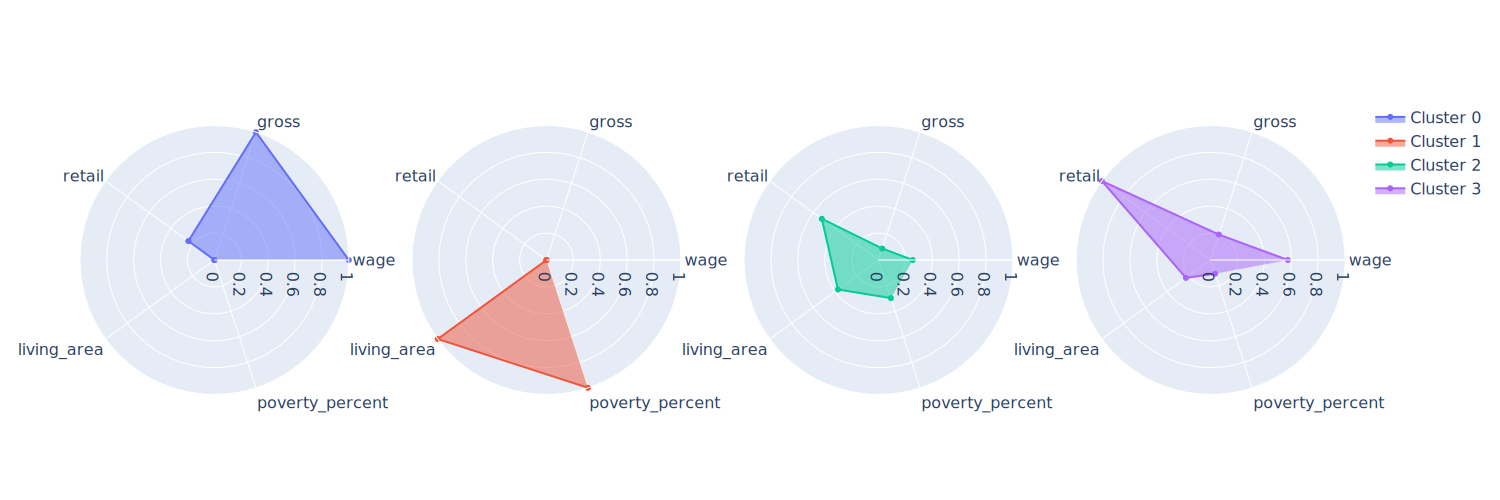

In [74]:
df['formal_wage_norm'] = df['formal_wage_paid'] / df['living_wage']
df['retail_norm'] = df['retail'] / df['living_wage']

cols = ['formal_wage_norm', 'gross', 'retail_norm', 'living_area', 'poverty_percent']
medians = df.groupby('cluster')[cols].median()

medians.rename(
    {'formal_wage_norm': 'wage', 'retail_norm': 'retail'}, 
    axis=1, inplace=True)
features = medians.columns
scaler = MinMaxScaler()
medians_scaled = pd.DataFrame(scaler.fit_transform(medians), 
                              columns=features)

fig = make_subplots(rows=1, cols=4, specs=[[{'type': 'polar'}]*4]*1)

fig.add_trace(go.Scatterpolar(  
    name = 'Cluster 0',
    r = medians_scaled.loc[0].values,
    theta = features,
    fill='toself',
    ), 1, 1)

fig.add_trace(go.Scatterpolar(
    name = 'Cluster 1',
    r = medians_scaled.loc[1].values,
    theta = features,
    fill='toself'
    ), 1, 2)

fig.add_trace(go.Scatterpolar(
    name = 'Cluster 2',
    r = medians_scaled.loc[2].values,
    theta = features,
    fill='toself'
    ), 1, 3)

fig.add_trace(go.Scatterpolar(
    name = "Cluster 3",
    r = medians_scaled.loc[3].values,
    theta = features,
    fill='toself'
    ), 1, 4)

fig.update_polars(radialaxis=dict(range=[0, 1]))
fig.update_layout(
    font_size=16,
    showlegend=True, # отображение легенды
    autosize=False, # устаналиваем свои размеры графика
    width=1500, 
    height=500) 
fig.show('svg')

In [75]:
display('Медианные значения в числовом выражении:', medians)

'Медианные значения в числовом выражении:'

,wage,gross,retail,living_area,poverty_percent
cluster,,,,,
0,4.061176,860733.340,10.313213,15.50,11.938462
1,2.405643,88804.132,6.873870,19.25,43.553846
2,2.827441,157884.150,14.358823,16.90,21.371154
3,3.357697,242351.276,21.234484,16.35,15.326923


In [76]:
df[df['cluster'] == 0].index


Index(['Ненецкий автономный округ', 'Ямало-Ненецкий автономный округ',
       'Магаданская область', 'Сахалинская область',
       'Чукотский автономный округ'],
      dtype='object', name='region')

**Кластер 0** характеризуется северными регионами, где наблюдается высокий уровень заработной платы, высокий валовой региональный продукт и наименьший процент бедного населения. Однако в этих регионах также имеется наименьшая жилая площадь на человека и средний уровень розничной торговли.

In [77]:
df[df['cluster'] == 1].index

Index(['Республика Калмыкия', 'Республика Ингушетия',
       'Карачаево-Черкесская Республика', 'Республика Тыва'],
      dtype='object', name='region')

**Кластер 1** характеризуется самым низким средним доходом на человека, высоким процентом бедности и низкими значениями розничной торговли и валового регионального продукта. Однако в этих регионах отмечается самая большая средняя площадь на человека.

In [78]:
df[df['cluster'] == 2].index

Index(['Брянская область', 'Владимирская область', 'Ивановская область',
       'Калужская область', 'Костромская область', 'Курская область',
       'Орловская область', 'Рязанская область', 'Смоленская область',
       'Тамбовская область', 'Тверская область', 'Тульская область',
       'Ярославская область', 'Республика Карелия', 'Республика Коми',
       'Архангельская область', 'Вологодская область',
       'Калининградская область', 'Ленинградская область',
       'Мурманская область', 'Новгородская область', 'Псковская область',
       'Республика Адыгея (Адыгея)', 'Республика Крым', 'Астраханская область',
       'Волгоградская область', 'Ростовская область', 'Севастополь',
       'Республика Дагестан', 'Кабардино-Балкарская Республика',
       'Республика Северная Осетия — Алания', 'Чеченская Республика',
       'Ставропольский край', 'Республика Марий Эл', 'Республика Мордовия',
       'Удмуртская Республика', 'Чувашская Республика — Чувашия',
       'Кировская область', 'Оре

**Кластер 2** является самым многочисленным и представляет собой средний уровень для регионов России. Здесь средняя заработная плата почти в 2,9 раза превышает прожиточный минимум, при этом валовый региональный продукт находится на относительно низком уровне. Высокий показатель розничной торговли характеризует этот кластер, а процент населения, находящегося в бедности, составляет около 1/5 от общего населения. Средний уровень жилой площади на человека также находится на уровне среднего значения для всей страны.

In [79]:
df[df['cluster'] == 3].index

Index(['Белгородская область', 'Воронежская область', 'Липецкая область',
       'Московская область', 'Москва', 'Санкт-Петербург', 'Краснодарский край',
       'Республика Башкортостан', 'Республика Татарстан (Татарстан)',
       'Пермский край', 'Нижегородская область', 'Свердловская область',
       'Ханты-Мансийский автономный округ — Югра', 'Тюменская область'],
      dtype='object', name='region')

**Кластер 3** включает в себя большинство регионов, расположенных в центральной части России, а также несколько регионов с Урала. В этом кластере наблюдается довольно высокий уровень заработной платы, относительно высокий валовый региональный продукт, и уровень бедности составляет около 15%. Этот кластер также характеризуется самым высоким показателем розничной торговли и средним уровнем жилой площади на человека.

Для проведения статистической оценки значимости обнаруженных различий между кластерами, как было продемонстрировано в предыдущей части проекта, учтем, что распределения исследуемых показателей не являются нормальными, и у нас более двух сравниваемых групп. В данном случае можно воспользоваться непараметрическим критерием Краскела-Уоллиса.

In [80]:
def kruskal_pvalue(df, col):
    "p-value для заданной колонки (значимость различий по 4-м кластерам)"
    v0 = df[df['cluster'] == 0][col]
    v1 = df[df['cluster'] == 1][col]
    v2 = df[df['cluster'] == 2][col]
    v3 = df[df['cluster'] == 3][col]
    _, p = kruskal(v0, v1, v2, v3)
    return p


cols = ['formal_wage_paid', 'gross', 'retail', 'living_area', 'poverty_percent']
for col in cols:
    print(f'{col}:   p-value = {kruskal_pvalue(df, col):.3f}')

formal_wage_paid:   p-value = 0.000
gross:   p-value = 0.000
retail:   p-value = 0.000
living_area:   p-value = 0.323
poverty_percent:   p-value = 0.000


Также необходимо провести анализ, чтобы определить, насколько обосновано выделять регионы в отдельный кластер 0, сравнивая эту группу с обычными регионами в кластере 2 с использованием критерия Манна-Уитни. Мы можем увидеть, что эти две группы действительно имеют существенные различия по всем параметрам, за исключением размера жилой площади.

In [81]:
def mannwhitney_pvalue(df, col, cl_couple):
    "p-value для пары кластеров (cl_couple) по заданной колонке"
    v0 = df[df['cluster'] == cl_couple[0]][col]
    v1 = df[df['cluster'] == cl_couple[1]][col]
    _, p = mannwhitneyu(v0, v1)
    return p

for col in cols:
    print(f'{col}:   p-value = {mannwhitney_pvalue(df, col, (0, 2)):.3f}')

formal_wage_paid:   p-value = 0.000
gross:   p-value = 0.000
retail:   p-value = 0.004
living_area:   p-value = 0.288
poverty_percent:   p-value = 0.001


#### 3.3.1 Группы населения, сталкивающиеся с бедностью

In [82]:
cols =[
    'children_per',
    'pensioners_per', 
    'working_age_per']
df[cols].mean()

children_per       38.945882
pensioners_per      5.631765
working_age_per    55.597647
dtype: float64

In [83]:
socgroups = df[[
    'population', 'poverty_percent', 'children_per',
    'pensioners_per', 'working_age_per', 
    'children_%', 'retired_percent']].copy()

# Процент трудоспособных
socgroups['employable_%'] = (
    100 - socgroups['children_%'] - socgroups['retired_percent']) 

# Количество малоимущих
socgroups['the_poor'] = (socgroups['population'] 
    * socgroups['poverty_percent'] / 100).round(0).astype(int)  

# Количество людей в социально-демографических группах
socgroups['children'] = (
    (socgroups['population'] * socgroups['children_%'] / 100)
    .round(0).astype(int))  
socgroups['employable'] = (
    (socgroups['population'] * socgroups['employable_%'] / 100)
    .round(0).astype(int))  
socgroups['retired'] = (
    (socgroups['population'] * socgroups['retired_percent'] / 100)
    .round(0).astype(int))  

# Количество малоимущих в социально-демографических группах
socgroups['poor_children'] = (  
    (socgroups['the_poor'] * socgroups['children_per'] / 100)
    .round(0).astype(int))
socgroups['poor_employable'] = (  
    (socgroups['the_poor'] * socgroups['working_age_per'] / 100)
    .round(0).astype(int))   
socgroups['poor_retired'] = (  
    (socgroups['the_poor'] * socgroups['pensioners_per'] / 100)
    .round(0).astype(int))    

# Процент малоимущих в социально-демографических группах
socgroups['poor_children_%'] = (
    (socgroups['poor_children'] / socgroups['children'] * 100))  
socgroups['poor_employable_%'] = (  
    (socgroups['poor_employable'] / socgroups['employable'] * 100))  
socgroups['poor_retired_%'] = ( 
    (socgroups['poor_retired'] / socgroups['retired'] * 100))  

# Среднее по РФ
cols =[
    'poor_children_%',
    'poor_employable_%', 
    'poor_retired_%']
poor_percent = socgroups[cols].mean()
poor_percent

poor_children_%      38.947188
poor_employable_%    22.052190
poor_retired_%        5.334812
dtype: float64

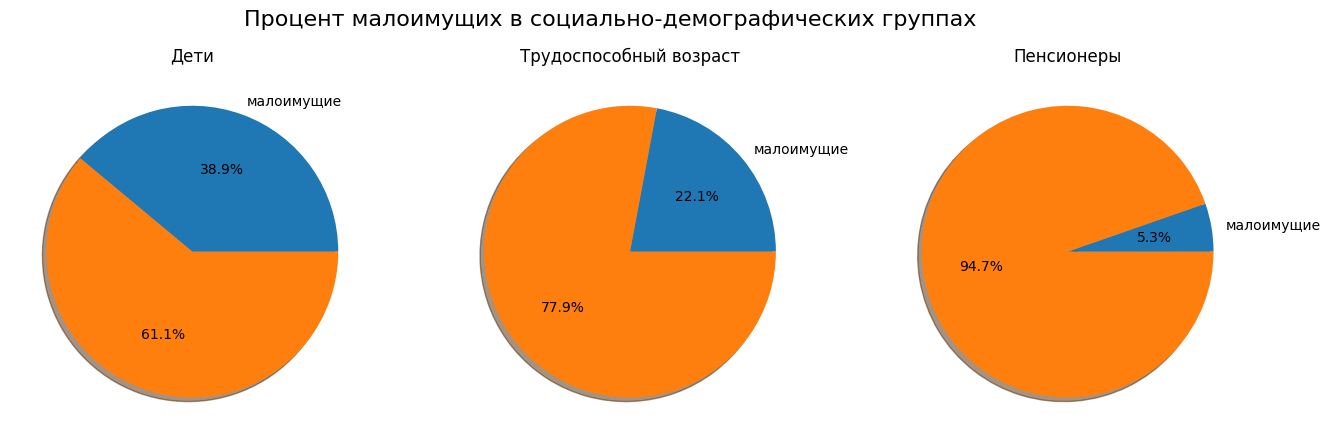

In [84]:
labels = ['малоимущие', '']
fig, ax = plt.subplots(1, 3, figsize=(16,5))
ax[0].pie([poor_percent[0], 100-poor_percent[0]], 
          labels=labels, autopct='%1.1f%%', shadow=True)
ax[1].pie([poor_percent[1], 100-poor_percent[1]], 
          labels=labels, autopct='%1.1f%%', shadow=True)
ax[2].pie([poor_percent[2], 100-poor_percent[2]], 
          labels=labels, autopct='%1.1f%%', shadow=True);
ax[0].set_title('Дети')
ax[1].set_title('Трудоспособный возраст')
ax[2].set_title('Пенсионеры')
fig.suptitle('Процент малоимущих в социально-демографических группах', fontsize=16)
fig.set_facecolor('white');

In [85]:
socgroups['cluster'] = df['cluster']
cluster_socgroups = (socgroups
    .groupby('cluster')[['children', 'employable', 'retired', 'poor_children',	
                         'poor_employable', 'poor_retired']].sum())

cluster_socgroups['poor_children_%'] = (cluster_socgroups['poor_children'] 
                                        / cluster_socgroups['children'] * 100)  
cluster_socgroups['poor employable %'] = (cluster_socgroups['poor_employable'] 
                                  / cluster_socgroups['employable'] * 100)  
cluster_socgroups['poor_retired %'] = (cluster_socgroups['poor_retired'] 
                                       / cluster_socgroups['retired'] * 100) 
cluster_socgroups

,children,employable,retired,poor_children,poor_employable,poor_retired,poor_children_%,poor employable %,poor_retired %
cluster,,,,,,,,,
0,299251,748842,220548,73452,73116,14370,24.545281,9.763875,6.515588
1,462866,865592,260186,246997,384655,42437,53.362528,44.438373,16.310255
2,17600229,46400654,21233545,7076814,10472058,1012426,40.208647,22.568772,4.768050
3,11460758,33149731,15154277,3646111,4901695,648963,31.813873,14.786530,4.282375


Рассмотрим аналогичные показатели для каждого кластера. В общем, эти показатели зависят от кластера: чем беднее регионы в кластере, тем выше процент людей, находящихся в бедности. Однако в случае кластера 0, который включает северные регионы, наблюдается более высокий процент бедных пенсионеров. Возможно, это связано с каким-то выбросом. В самом бедном кластере, кластере 1, процент бедных значительно выше по сравнению с другими кластерами.

#### 3.3.2 Взаимосвязь численности социально-демографических групп с уровнем бедности

,children,employable,retired,poor_children,poor_employable,poor_retired,poor_children_%,poor employable %,poor_retired %,population,children_%,employable_%,retired_%
cluster,,,,,,,,,,,,,
0,299251,748842,220548,73452,73116,14370,24.545281,9.763875,6.515588,1268641,23.588312,59.027101,17.384587
1,462866,865592,260186,246997,384655,42437,53.362528,44.438373,16.310255,1588642,29.135954,54.486285,16.377888
2,17600229,46400654,21233545,7076814,10472058,1012426,40.208647,22.568772,4.768050,85234426,20.649202,54.438865,24.911935
3,11460758,33149731,15154277,3646111,4901695,648963,31.813873,14.786530,4.282375,59764764,19.176447,55.467016,25.356541


Нулевая гипотеза: процент детей в разных кластерах одинаков
chi-square test p-value = 0.0


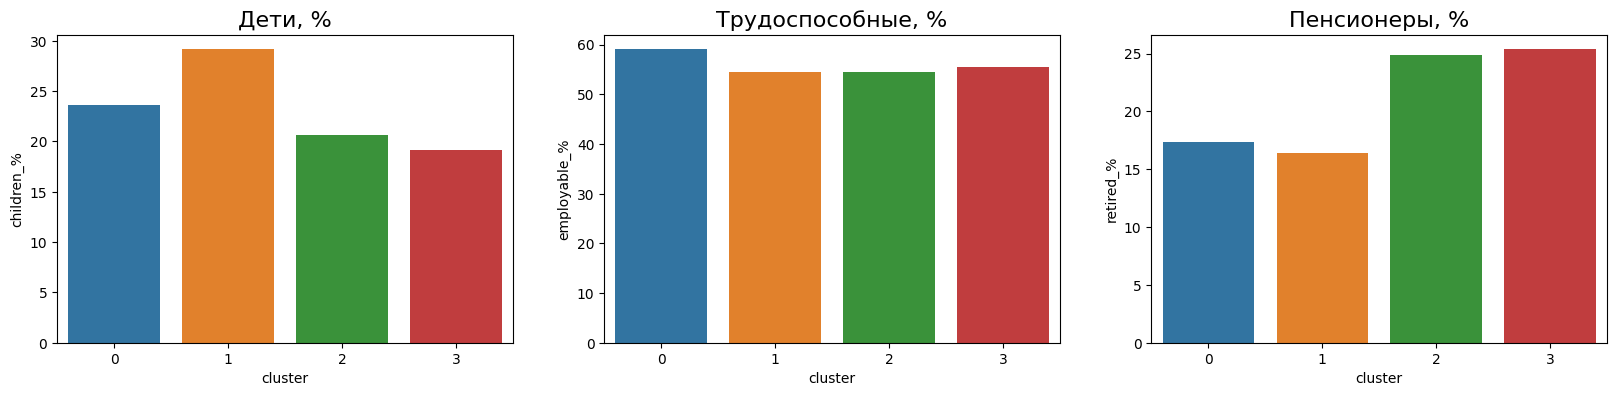

In [86]:
cluster_socgroups['population'] = (df.groupby('cluster')['population']
                                   .sum().astype(int))
cluster_socgroups['children_%'] = (cluster_socgroups['children'] 
                                   /  cluster_socgroups['population'] * 100)
cluster_socgroups['employable_%'] = (cluster_socgroups['employable'] 
                                   /  cluster_socgroups['population'] * 100)
cluster_socgroups['retired_%'] = (cluster_socgroups['retired'] 
                                   /  cluster_socgroups['population'] * 100)
display(cluster_socgroups)

fig, ax  = plt.subplots(1, 3, figsize=(20, 4))
ax[0].bar(cluster_socgroups.index, cluster_socgroups['children_%'])
sns.barplot(data=cluster_socgroups, 
            x=cluster_socgroups.index, y='children_%', ax=ax[0])
sns.barplot(data=cluster_socgroups, 
            x=cluster_socgroups.index, y='employable_%', ax=ax[1])
sns.barplot(data=cluster_socgroups, 
            x=cluster_socgroups.index, y='retired_%', ax=ax[2])
ax[0].set_title('Дети, %', fontsize=16)
ax[1].set_title('Трудоспособные, %', fontsize=16)
ax[2].set_title('Пенсионеры, %', fontsize=16)

stat, p, tab = proportions_chisquare(
    cluster_socgroups['children'], cluster_socgroups['population'])
print('Нулевая гипотеза: процент детей в разных кластерах одинаков')
print(f'chi-square test p-value = {p}');

Из анализа таблицы и графиков видно, что самый высокий процент детей находится в самом малоимущем регионе, при этом количество пенсионеров там наименьшее. Больший процент пенсионеров наблюдается в средних кластерах. Распределение трудоспособного населения примерно одинаково, с небольшим приростом в 'Северном' кластере.

Нулевая гипотеза: рождаемость не зависит от кластера
Kruskal-Wallis p-value = 0.000


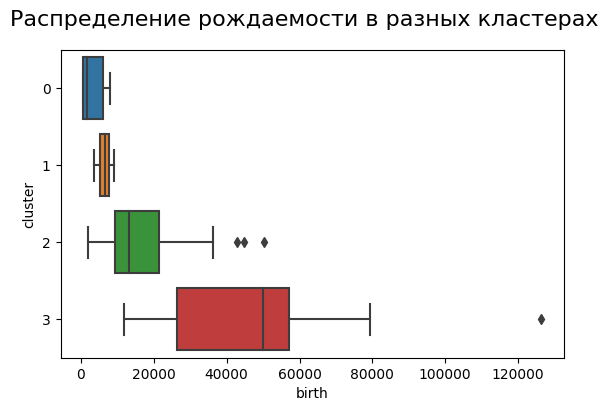

In [87]:
fig = plt.figure(figsize=(6.5, 4))
sns.boxplot(data=df, x='birth', y='cluster', orient='h')
fig.suptitle('Распределение рождаемости в разных кластерах',fontsize=16);

print('Нулевая гипотеза: рождаемость не зависит от кластера')
print(f"Kruskal-Wallis p-value = {kruskal_pvalue(df, 'birth'):.3f}")

Денежное благополучие не демонстрирует явной зависимости от уровня рождаемости детей. Наблюдается самая высокая рождаемость в регионах центральной России.

In [88]:
# Нормируем пенсию на размер потребительской корзины
df['pension_norm'] = df['pension'] / df['living_wage']
# Пересчитываем кол-во преступлений на 100 тыс. населения
# Кол-во детей в детских домах на 100 тыс. населения
df['orphanage'] = (
    df['orphans_need'] / df['population'] * 100_000)

cols = ['cash_capita','formal_wage_paid','child_mortality','disabled','alco','drugs','gross','living_area','poor_living_conditions','general_morbidity',
'teen_pregnancy','birth','poverty_percent','children_per','pensioners_per','working_age_per','reg_mining','reg_electric','reg_water',
'reg_manuf','reg_indust','retail','orphans_need','adopted','retiree','pension','living_wage','children_%','population',
'retired_percent', 'crime']

cols_s = cols.copy()
for col in cols:
    p = kruskal_pvalue(df, col)
    print(f'{col}:   p-value = {p:.3f}')
    if p > 0.05: 
        cols_s.remove(col)

cash_capita:   p-value = 0.000
formal_wage_paid:   p-value = 0.000
child_mortality:   p-value = 0.000
disabled:   p-value = 0.000
alco:   p-value = 0.000
drugs:   p-value = 0.357
gross:   p-value = 0.000
living_area:   p-value = 0.323
poor_living_conditions:   p-value = 0.450
general_morbidity:   p-value = 0.041
teen_pregnancy:   p-value = 0.001
birth:   p-value = 0.000
poverty_percent:   p-value = 0.000
children_per:   p-value = 0.009
pensioners_per:   p-value = 0.949
working_age_per:   p-value = 0.052
reg_mining:   p-value = 0.001
reg_electric:   p-value = 0.000
reg_water:   p-value = nan
reg_manuf:   p-value = 0.000
reg_indust:   p-value = 0.000
retail:   p-value = 0.000
orphans_need:   p-value = 0.001
adopted:   p-value = 0.000
retiree:   p-value = 0.000
pension:   p-value = 0.001
living_wage:   p-value = 0.002
children_%:   p-value = 0.004
population:   p-value = 0.000
retired_percent:   p-value = 0.001
crime:   p-value = 0.000


Кластеры не имеют статистически значимых различий в следующих характеристиках: уровень наркомании, средняя жилая площадь на человека, плохие жилищные условия, заболеваемость, процент детей, процент пенсионеров и процент людей рабочего возраста в семьях, находящихся за чертой бедности.

Давайте построим графики распределения для характеристик, в которых наблюдаются статистически значимые различия.

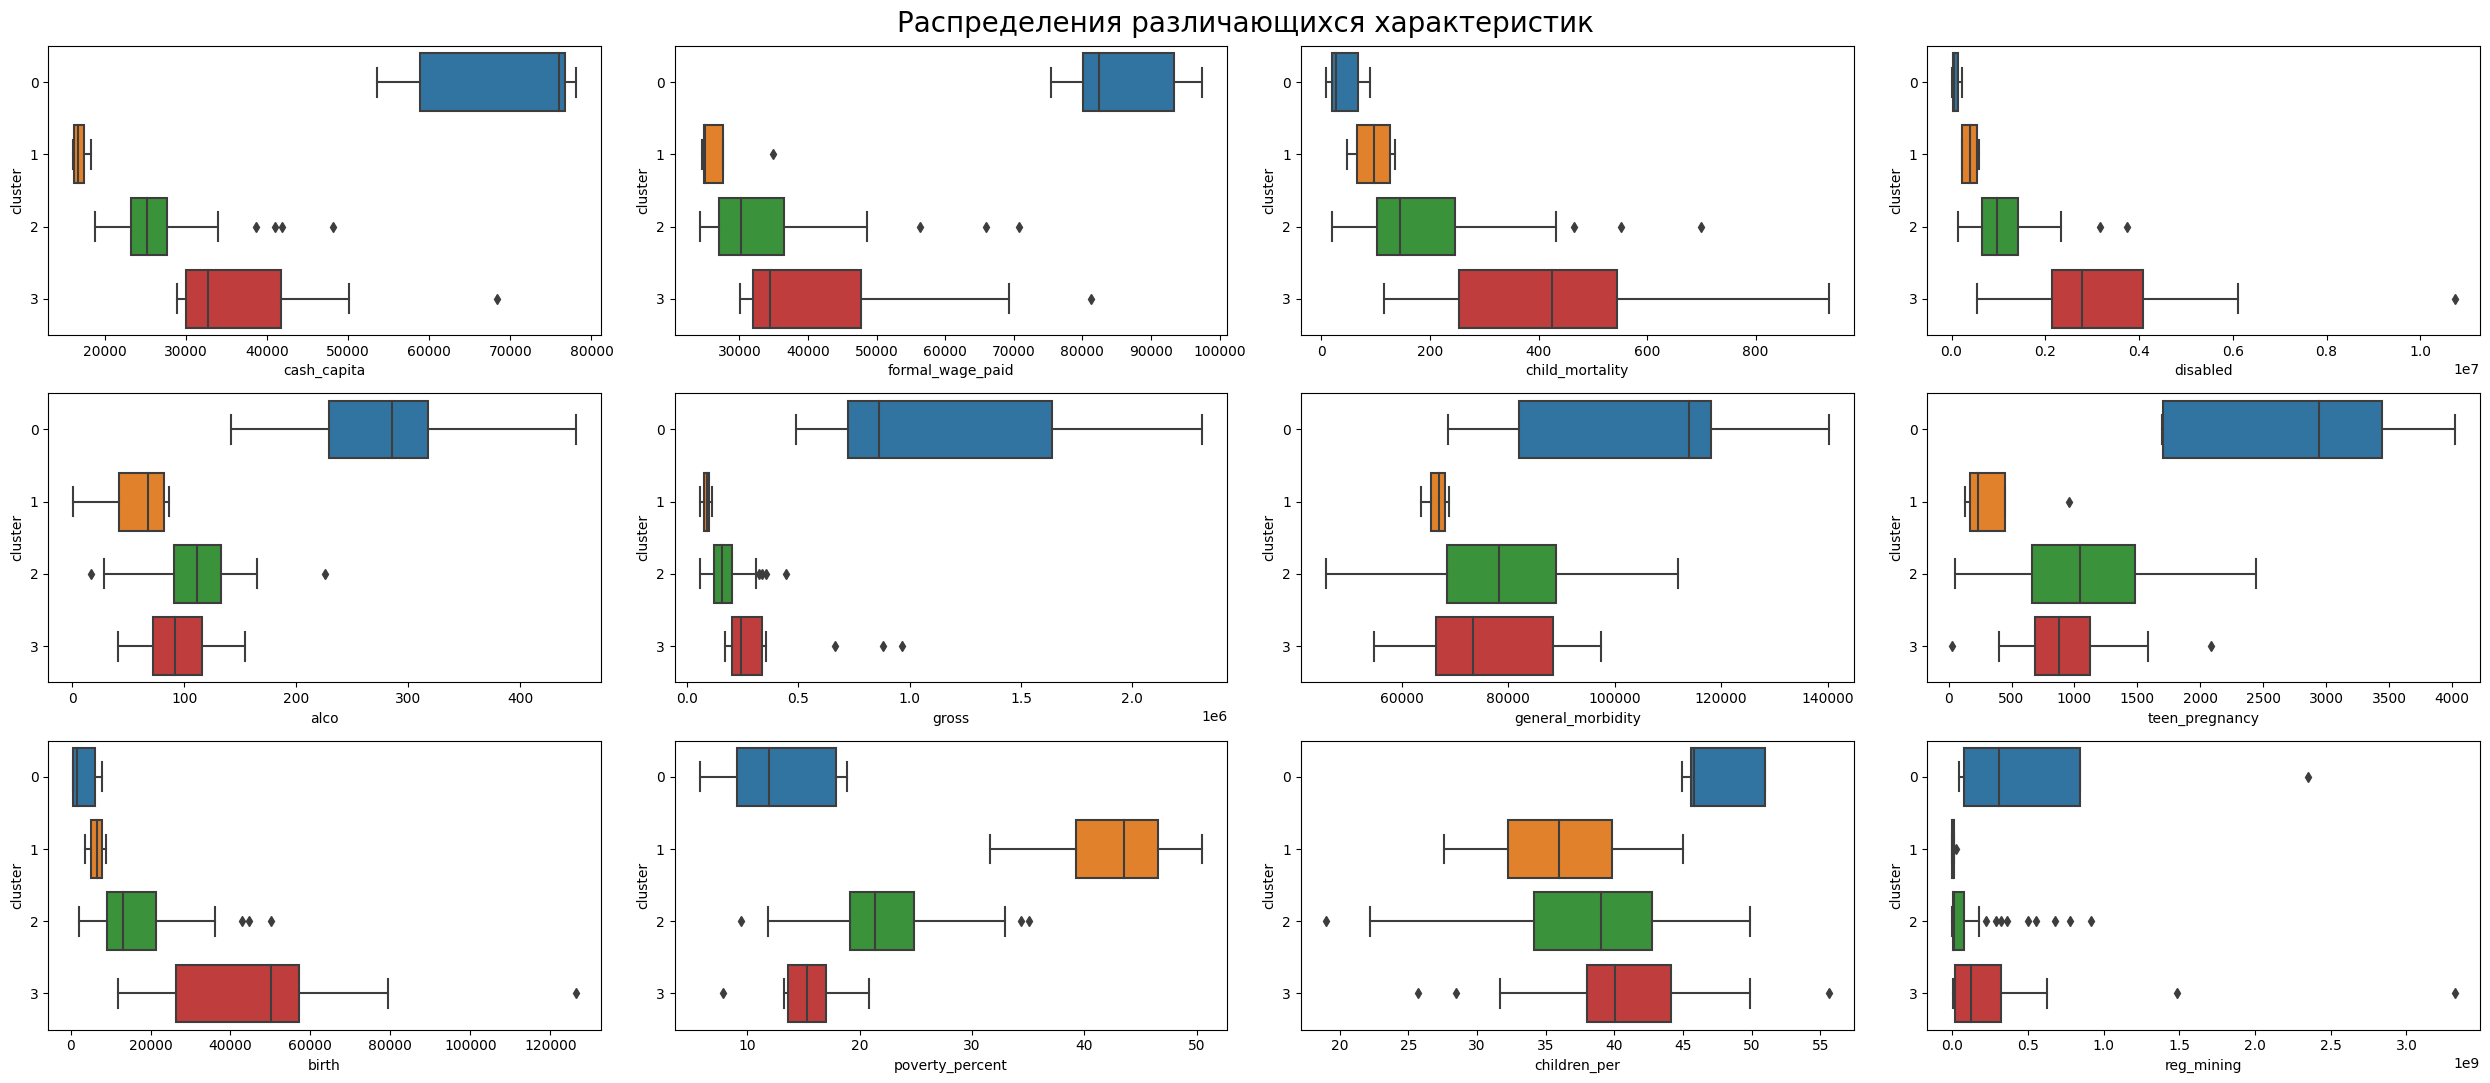

In [89]:
fig, ax = plt.subplots(3, 4, figsize=(25, 11))
i = 0
for row in range(3):
    sns.boxplot(data=df, x=cols_s[i], y='cluster', orient='h', ax=ax[row,0])
    sns.boxplot(data=df, x=cols_s[i+1], y='cluster', orient='h', ax=ax[row,1])
    sns.boxplot(data=df, x=cols_s[i+2], y='cluster', orient='h', ax=ax[row,2])
    sns.boxplot(data=df, x=cols_s[i+3], y='cluster', orient='h', ax=ax[row,3])
    i += 4
fig.suptitle('Распределения различающихся характеристик', 
             fontsize=20)
plt.tight_layout()

Анализ распределений:

* **Среднемесячный доход:** Самый высокий средний доход наблюдается в "Северных" регионах (кластер 0), затем идут регионы Центральной Федерального Округа (Центральный ФО), а самый низкий уровень дохода в "беднейших" регионах (кластер 1).
* **Прожиточный минимум:** Распределение прожиточного минимума соответствует распределению доходов: наивысший в "Северных" регионах, затем в Центральном ФО, и наименьший в "беднейших" регионах.
* **Детская смертность:** Несмотря на большее количество детей в "беднейших" регионах, детская смертность оказалась наибольшей в регионах Центрального ФО, затем идут "Северные" регионы, и наименьшая детская смертность в "беднейших" регионах.
* **Люди с ограниченными физическими возможностями:** Больше всего людей с ограниченными физическими возможностями в Центральном ФО, затем идут "Северные" регионы, а меньше всего таких людей в "беднейших" регионах.
* **Алкоголизм:** Проблемы с алкоголизмом наиболее распространены в "Северных" регионах, затем в "наибольшем" кластере, и наименьший уровень алкоголизма в "беднейших" регионах.
* **Валовый региональный продукт (ВРП):** Самый высокий ВРП наблюдается в "Северных" регионах, а самый низкий в "беднейших" регионах.
* **Подростковая беременность:** Подростковая беременность наиболее распространена в "Северных" регионах, за ними следует Центральный ФО, и наименьшее количество случаев в "беднейших" регионах.
* **Рождаемость:** Показатель рождаемости отображается несколько необычно, и, возможно, требует коррекции, так как, несмотря на большее количество детей в "беднейших" регионах, рождаемость оказалась наибольшей в "Северных" регионах.
* **Процент населения за чертой бедности:** Наибольший процент населения, живущего за чертой бедности, наблюдается в "беднейших" регионах, а наименьший в "Северных" регионах.
* **Процент детей в малоимущих семьях:** Самый высокий процент детей в малоимущих семьях наблюдается в "Северных" регионах, затем идут регионы Центрального ФО, и в "беднейших" регионах этот показатель меньше.
* **Добыча полезных ископаемых:** Наиболее развита добыча полезных ископаемых в "Северных" регионах, затем в Центральном ФО, и "наибольшем" кластере также присутствуют значительные значения, возможно, связанные с промышленностью.

Ячейка ниже позволяет посмотреть лидеров и аутсайдеров по какой-либо характеристике внутри кластера.

In [90]:
col = 'living_wage'  # колонка
cluster = 2          # кластер

mask = df['cluster'] == cluster
df[mask][col].sort_values(ascending=False)

region
Камчатский край                 21524.0
Республика Саха (Якутия)        17824.0
Мурманская область              17723.0
Хабаровский край                15569.0
Еврейская автономная область    15416.0
                                 ...   
Ставропольский край              9777.0
Оренбургская область             9760.0
Саратовская область              9631.0
Пензенская область               9610.0
Республика Мордовия              9378.0
Name: living_wage, Length: 62, dtype: float64

## Вывод

В результате анализа данных были выделены следующие кластеры:

1. **Наиболее богатые регионы**: Кластер, характеризующийся высоким уровнем дохода и благополучия.

2. **Бедные регионы**: Кластер, представляющий собой регионы с низким уровнем дохода и социально-экономическими трудностями.

3. **Регионы средние, большое количество регионов**: Кластер, включающий в себя множество регионов со средними показателями.

4. **Регионы средние, преимущественно Центральный ФО**: Кластер, где большинство регионов принадлежат Центральному Федеральному Округу и характеризуются средним уровнем дохода.

Проведен анализ социально-демографических групп населения, и выявлено, что наиболее уязвимыми в финансовом плане являются семьи с детьми. Однако в кластере самых бедных регионов наблюдается низкая рождаемость, что, возможно, связано с ошибкой в данных по рождаемости. Вероятнее всего, следует считать, что в бедных регионах больше детей, и, следовательно, рождаемость тоже выше. Поскольку количество детей увеличивает финансовую нагрузку на родителей. Доля детей среди населения в этих регионах на 10% выше, чем в других регионах.

В остальных аспектах процент детей не сильно зависит от региона. На втором месте по количеству детей населения находятся Северные регионы, а затем идут средние регионы. В бедных регионах значительно меньше людей пенсионного возраста (менее 15%).

Также был проведен анализ различий в других характеристиках набора данных по кластерам. Более подробное описание имеющихся корреляций представлено выше.